# CE 5362 Lesson 9 Unsteady Open Channel Flow
---

Refining the Lax-Scheme to generalize and explore some different examples.

## Finite-Difference Method for Unsteady Open Channel Flow

 The simplest form of solution that is conditionally stable and reasonably straightforward to program is called the Lax-Diffusion scheme.  Recall our difference equations derived from continunity:

\begin{equation}
\begin{matrix}
y_i^{t+\Delta t} = \frac{1}{2}(y_{i-1}^t+y_{i+1}^t) -\frac{r}{2}(\frac{A}{B}\vert_{i-1}^t + \frac{A}{B}\vert_{i+1}^t)(V_{i+1}^{t}-V_{i-1}^t)-\frac{r}{2}(V_{f,i-1}^t + V_{f,i+1}^t)(y_{i+1}^{t}-y_{i-1}^t) \\
~\\
 \end{matrix}
 \label{eqn:lax-continunity}
\end{equation}


and momentum:

\begin{equation}
\begin{matrix}
V_i^{t+\Delta t}=\frac{1}{2}(V_{i-1}^t+V_{i+1}^t) +
\Delta t  g(S_0-\frac{1}{2}(S_{f,i-1}^t + S_{f,i+1}^t))
- \frac{r}{2}(V_{i-1}^t+V_{i+1}^t) (V_{i+1}^{t}-V_{i-1}^t)
-rg(y_{i+1}^{t}-y_{i-1}^t)\\
~\\
\end{matrix}
\label{eqn:lax-momentum}
\end{equation}

### Example Non-Prismatic Channel - Still a Steady Flow Case
A plan view of a rectangular channel of variable width as shown in Figure 1


![](NonPrismaticExample1.jpg)

|Figure 1. Non-Prismatic Rectangular Channel|
|---|

The channel conveys $Q=100~m^3/sec$, with a bottom slope of $0.001$ and average Manning's $n$ value of $0.033$.  A backwater curve is caused by a weir at the downstream end (to the right in the figure) by a 7 meter tall weir.
Flow depth over the weir is at critical depth $h_c = 2.17$ meters.  Normal flow in the upstream portion for 10-meter channel width is $h_n = 5.6$ meters.  Using the unsteady solver, run the solver until an equilibrium solution is returned and compare the result to either the same case in the fixed-step steady flow solver, or SWMM.

As with our prior example, we will just modify our script a bit to handle the changing geometry. In this example we will place the script into three sub-blocks to facilitate changes and re-running after those changes.

In [96]:
import math # python package for various common math functions
import matplotlib # python plotting package

########## prototype hydraulic functions #####################
# hydraulic functions for trapezoidal channels
# depth == flow depth          
# bottom == bottom width of trapezoidal channel
# side == side slope (same value both sides) of trapezoidal channel
# computed values:
# bt == computed topwidth :: ar == flow area, used in fd update :: wp == wetted perimeter, used in fd update

def bt(depth,bottom,side):   # depth-topwidth function
    topwidth = (bottom + 2.0*side*depth);
    return(topwidth);

def ar(depth,bottom,side):  # depth area function
    area = (depth*(bottom+side*depth));
    return(area)

def wp(depth,bottom,side):   # depth perimeter
    import math
    perimeter = (bottom+2.0*depth*math.sqrt(1.0+side*side));
    return(perimeter)

######### prototype display functions #########################

def writenow(t,dt,y,v,b0,s): # printing functions
    print("__________")
    print("Time = ",t," seconds.","Time step length = ",dt," seconds ")
    print("IROW "," DEPTH "," VELOCITY ")
    for irow in range(0,len(v)):
        print(irow,round(y[irow],3),round(v[irow],3))
    return()  #observe a NULL return, this function messages to the output device, so there is nothing to return.

def plot2lines(list1,list2,list3,list4,strx,stry,strtitle): # plot list1 on x, list2 on y, xlabel, ylabel, title
    from matplotlib import pyplot as plt # import the plotting library from matplotlibplt.show()
    myfigure = matplotlib.pyplot.figure(figsize = (16,8))
    plt.plot( list1, list2, color ='brown', marker ='', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.plot( list3, list4, color ='blue', marker ='', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.title(strtitle)# add a title
    plt.ylabel(stry)# add a label to the x and y-axes
    plt.xlabel(strx)
    plt.show() # display the plot
    return #null return

Our problem constants are modified in this instance as in the fragment below, this block is mostly input conditions and some prerptory calculations before the hydraulics model -- observe how we have added vecotrs for geometry in this case.

In [97]:
###### Problem Constants and Input Block #######
# simulation domain
l = 30000.0 # total length (the length of computational domain)
n = 30 # number of reaches
# physical constants
g = 9.81 # gravitational acceleration, obviously SI units

q0 = 100.0 # initial discharge
yd = 9.17 # initial flow depth in the model
yu = 5.60 # upstream constant depth
mn = 0.033 # Manning's n
s0 = 0.001 # longitudinal slope (along direction of flow)

tmax = 86000 # total simulation time in seconds (one day in this case)
iprt =  1000 # print every iprt time steps (make big to suppress output)
nn = n+1 # how many nodes, will jack with boundaries later
mn2 = mn*mn # Manning's n squared, will appear a lot.
######## Here we build storage vectors ###############
bw = [0]*nn # bottom width vector 
ss = [0]*nn # side slope vector
#### Geometry
bw = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,8,7,8,9,10,11,12,13,14,13,12,11,10,10,10]
ss = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#### Initial Velocity 
a = ar(yd,bw[n],ss[n]) # flow area at beginning of time
v0 = q0/a # initial velocity
#### depth and velocity vectors
y = [0]*nn # create nn elements of vector y, all zero
yp = [0]*nn # updates go in this vector, same length as y
v = [0]*nn # create nn elements of vector v
vp = [0]*nn # updates go in this vector, same length and v
ytmp = [0]*nn
vtmp = [0]*nn
y = [float(yd) for i in y] # populate y with nn things, each thing has value yd
v = [float(v0) for i in y] # populate v with nn things, each thing has value v0
### Build the output geometry
b = bt(y[n],bw[n],ss[n]) # topwidth at downstream end
c = math.sqrt(g*a/b) # celerity at initial conditions
dx = l/n # delta x, length of a reach
xx = [dx*(i) for i in range(0,nn)] # Spatial locations of nodes, used for plotting
bse = [30 - s0*xx[i] for i in range(0,nn)] # bottom channel elevation
wse = [bse[i]+y[i] for i in range(0,nn)] # water surface elevation
dt = dx/(v0 + c) # the time step that satisfies the courant condtions
kmax = round(tmax/dt)  # set maximum number of time steps
print('Celerity = ',round(c,3) )
print('Delta x  = ',round(dx,3))
print('Delta t  = ',round(dt,3))
print("ITmax = ",(kmax))

Celerity =  9.485
Delta x  =  1000.0
Delta t  =  94.562
ITmax =  909


__________
Time =  0.0  seconds. Time step length =  184.3611886300177  seconds 
IROW   DEPTH   VELOCITY 
0 5.6 1.827
1 5.603 1.828
2 5.607 1.828
3 5.612 1.827
4 5.618 1.827
5 5.626 1.826
6 5.636 1.825
7 5.649 1.823
8 5.665 1.822
9 5.685 1.82
10 5.71 1.817
11 5.742 1.814
12 5.78 1.809
13 5.831 1.807
14 5.883 1.781
15 5.929 1.765
16 5.941 1.702
17 5.931 1.724
18 5.917 1.702
19 5.918 1.756
20 5.973 1.783
21 6.08 1.801
22 6.244 1.806
23 6.473 1.801
24 6.764 1.766
25 7.11 1.724
26 7.502 1.658
27 7.924 1.589
28 8.374 1.522
29 8.898 1.505
30 9.17 1.091
__________
Time =  83792.16026492136  seconds. Time step length =  184.3611887053591  seconds 
IROW   DEPTH   VELOCITY 
0 5.6 1.827
1 5.603 1.828
2 5.607 1.828
3 5.612 1.827
4 5.618 1.827
5 5.626 1.826
6 5.636 1.825
7 5.649 1.823
8 5.665 1.822
9 5.685 1.82
10 5.71 1.817
11 5.742 1.814
12 5.78 1.809
13 5.831 1.807
14 5.883 1.781
15 5.929 1.765
16 5.941 1.702
17 5.931 1.724
18 5.917 1.702
19 5.918 1.756
20 5.973 1.783
21 6.08 1.801
22 6.244 1.80

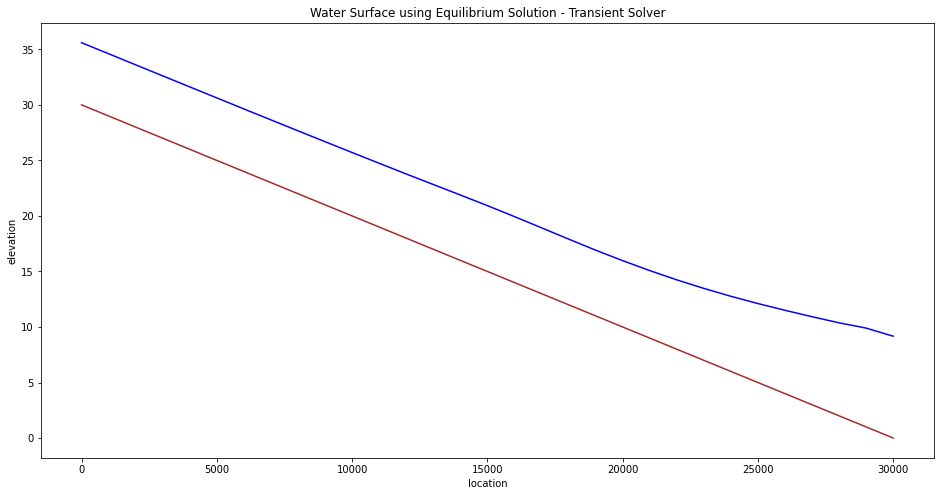

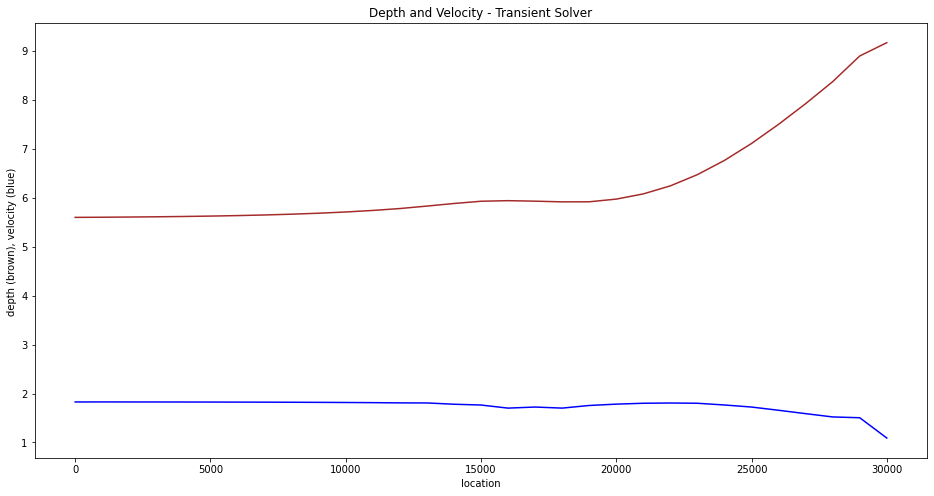

In [99]:
k = 0 # time counter
t = 0.0 # elapsed time
writenow(t,dt,y,v,bw[0],ss[0]) #print the start conditions
for itime in range(0,kmax): # begin time stepping loop scope
#print('Iteration Count = ',itime)
######## Adaptive Time Step Based on Current mesh courant number ###
    bestdt = dt # start with current time step
### begin courant number each cell loop scope
    for i in range(0,nn):
        a = ar(y[i],bw[i],ss[i]);
        b = bt(y[i],bw[i],ss[i]);
        c = math.sqrt(g*a/b);
        dtn = dx/abs((v[i])+c)
    # now test
        if(dtn < bestdt):
            bestdt = dtn
### end courant number each cell loop scope
    dt = bestdt
#print('time-step length = ',dt)
#writenow(t,dt,y,v,b0,s)


###### Finite Difference #################################
    r = 0.5*dt/dx;
###### LEFT BOUNDARY #####################################
# UPSTREAM FIXED STAGE AT PRESCRIBED NORMAL DEPTH        #
##########################################################
    yp[0] = yu
    ab = ar(y[1],bw[1],ss[1]);
    bb = bt(y[1],bw[1],ss[1]);
    cb = math.sqrt(g*bb/ab);
    rb = ab/wp(y[1],bw[1],ss[1]);
    sfb = (mn2*v[1]*v[1])/(rb**(1.333));
    cn = v[1] -cb*y[1]+ g*(s0-sfb)*dt;
    vp[0] = cn + cb*yp[0];
###### RIGHT BOUNDARY ####################################
#         FIXED STAGE AT DOWNSTREAM END                  #
##########################################################
# reflection boundary, find velocity along a characteristic
    yp[n-1] = yd ;
    aa = ar(y[n-1],bw[n-1],ss[n-1]);
    ba = bt(y[n-1],bw[n-1],ss[n-1]);
    ca = math.sqrt(g*ba/aa);
    ra = aa/wp(y[n-1],bw[n-1],ss[n-1]);
    sfa = (mn2*v[n-1]*v[n-1])/(ra**(4.0/3.0));
    cp = v[n-1] + ca*y[n-1]+g*(s0-sfa)*dt;
##yp[nn] <<- (cp - vp[nn])/ca;
    vp[n] = cp - yp[n]*ca 
######## INTERIOR NODES AND REACHES ###############
### loop through the interior nodes
    for i in range(1,n): # begin interior node loop scope
        aa = ar(y[i-1],bw[i-1],ss[i-1]);
        ba = bt(y[i-1],bw[i-1],ss[i-1]);
        pa = wp(y[i-1],bw[i-1],ss[i-1]);
        ra = aa/pa;
        sfa = (mn2*v[i-1]*v[i-1])/(ra**(4.0/3.0));
        ab = ar(y[i+1],bw[i+1],ss[i+1]);
        bb = bt(y[i+1],bw[i+1],ss[i+1]);
        pb = wp(y[i+1],bw[i+1],ss[i+1]);
        rb = ab/pb;
        sfb = (mn2*v[i+1]*v[i+1])/(rb**(4.0/3.0));
# need averages of sf, hydraulic depth
        dm = 0.5*(aa/ba + ab/bb);
        sfm = 0.5*(sfa+sfb);
        vm = 0.5*(v[i-1]+v[i+1]);
        ym = 0.5*(y[i-1]+y[i+1]);
# new momentum
        vp[i] = vm -r*g*(y[i+1] - y[i-1]) -r*vm*(v[i+1] - v[i-1]) + g*dt*(s0-sfm);
# new depth
        yp[i] = ym - r*dm*(v[i+1] - v[i-1]) -r*vm*(y[i+1] - y[i-1]);
### end of interior node loop scope
# update time, count, depth and momentum
    t = t+dt; # Increment simulation time
    k = k+1; # Increment loop counter
    for i in range(0,n):
        v[i]=vp[i]
        y[i]=yp[i]
    if (k%iprt == 0): # Write current conditions every iprt time steps
        writenow(t,dt,y,v,b0,s)
    dt = 2*dt #artificially inflate the time step to force adaptive update
# end time step loop

# provisional code to make a plot
writenow(t,dt,y,v,bw[0],ss[0])
for i in range(0,nn):
    wse[i]=bse[i]+y[i]
plot2lines(xx,bse,xx,wse,"location","elevation","Water Surface using Equilibrium Solution - Transient Solver")


In [100]:
# copy from lesson 6
depth_steady_solver = [9.17,8.459000000000003,7.813,7.206000000000003,6.584,5.969,5.379000000000002,4.889,4.665,4.701,4.931999999999999,5.306000000000003,5.810000000000002,6.467000000000001,6.9,6.819000000000002,6.532,6.202000000000002,5.960000000000001,5.791999999999998,5.681999999999999,5.612,5.568000000000001,5.5409999999999995,5.525000000000001,5.5150000000000015,5.509000000000003,5.506000000000002,5.504000000000001,5.502000000000001,  5.502000000000001]
depth_unsteady_solver = [0]*nn
for i in range(n,-1,-1):
    depth_unsteady_solver[i] = y[n-i]
difference = []
for i in range(len(y)):
    difference.append(100*(depth_steady_solver[i]-depth_unsteady_solver[i])/depth_steady_solver[i])

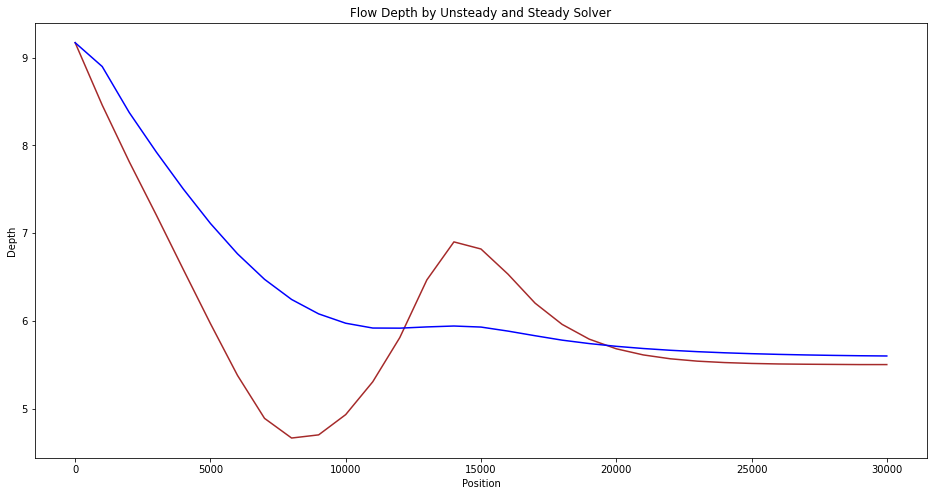

In [101]:
plot2lines(xx,depth_steady_solver,xx,depth_unsteady_solver,"Position","Depth","Flow Depth by Unsteady and Steady Solver")

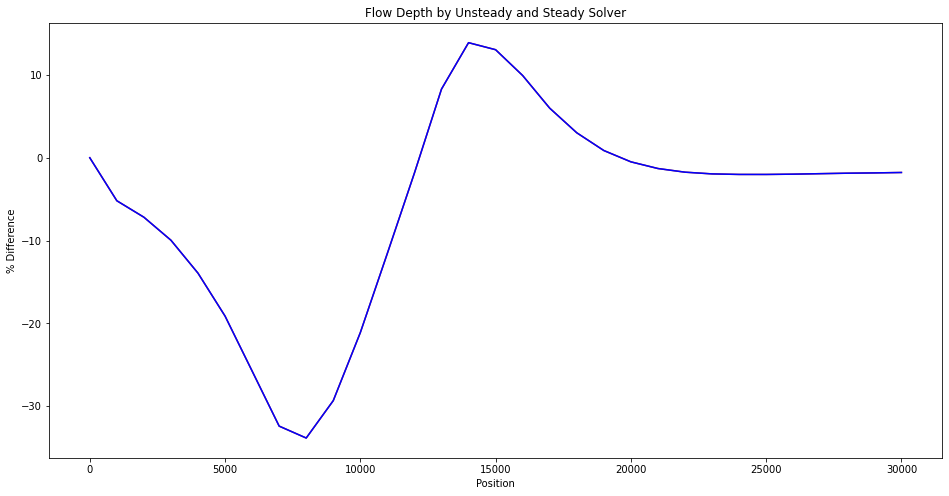

In [102]:
plot2lines(xx,difference,xx,difference,"Position","% Difference","Flow Depth by Unsteady and Steady Solver")

In [103]:
depth_unsteady_solver

[9.17,
 8.898428047165453,
 8.3740911155776,
 7.923823472218373,
 7.5016975711744935,
 7.110289342570108,
 6.764321787546651,
 6.473452221255093,
 6.243943424848816,
 6.079777041632525,
 5.97329661226047,
 5.918375952384603,
 5.9170602715170935,
 5.931105290200911,
 5.941398522084115,
 5.929472932033026,
 5.883497635533039,
 5.830741734850848,
 5.7803588261191585,
 5.741518112256614,
 5.7100922633568345,
 5.685044007381764,
 5.665040961460659,
 5.649100180269826,
 5.636405868568413,
 5.626305209560977,
 5.618273094127333,
 5.611888572857573,
 5.6068204572618185,
 5.60274842085939,
 5.6]

## Example Transient Flow in Sudden Channel Closure
Now lets modify our script to consider the following example problem:
- Flow in a 1000-m long trapezoidal channel with a bottom width of 20-m, side slopeof 2H:1V, 
- Longitudinal slope $S_0$=0.0001,
- Manning’s resistance n=0.013.  
- Initial discharge in the channel is 110 $\frac{m^3}{s}$ 
- Initial flow depth is 3.069 m.  

Simulate theflow  and  depth  at  every  100-m  station  when  a  downstream  gate  is  closed  at  t=0.

Produce a graph of depth and velocity versus location for t=0, 60, 360 seconds.

This example is derived from Hydraulic Engineering Roberson, J. A., Cassidy, J.J.,and Chaudry, M. H., (1988) Hydraulic Engineering, Houghton Mifflin Co.  It is iden-tical to the example in that book starting on page 623. (Chapter 12 on the server copy)

In [109]:
###### Problem Constants and Input Block #######
# simulation domain
l = 1000.0 # total length (the length of computational domain)
n = 10 # number of reaches
# physical constants
g = 9.81 # gravitational acceleration, obviously SI units

q0 = 110.0 # initial discharge
yd = 3.069 # initial flow depth in the model
yu = 3.069 # upstream constant depth
mn = 0.013 # Manning's n
s0 = 0.001 # longitudinal slope (along direction of flow)

tmax = 866600 # total simulation time in seconds (one day in this case)
iprt =  1000 # print every iprt time steps (make big to suppress output)
nn = n+1 # how many nodes, will jack with boundaries later
mn2 = mn*mn # Manning's n squared, will appear a lot.
######## Here we build storage vectors ###############
bw = [0]*nn # bottom width vector 
ss = [0]*nn # side slope vector
#### Geometry
bw = [20,20,20,20,20,20,20,20,20,20,20]
ss = [2,2,2,2,2,2,2,2,2,2,2]
#### Initial Velocity 
a = ar(yd,bw[n],ss[n]) # flow area at beginning of time
v0 = q0/a # initial velocity
#### depth and velocity vectors
y = [0]*nn # create nn elements of vector y, all zero
yp = [0]*nn # updates go in this vector, same length as y
v = [0]*nn # create nn elements of vector v
vp = [0]*nn # updates go in this vector, same length and v
ytmp = [0]*nn
vtmp = [0]*nn
y = [float(yd) for i in y] # populate y with nn things, each thing has value yd
v = [float(v0) for i in y] # populate v with nn things, each thing has value v0
### Build the output geometry
b = bt(y[n],bw[n],ss[n]) # topwidth at downstream end
c = math.sqrt(g*a/b) # celerity at initial conditions
dx = l/n # delta x, length of a reach
xx = [dx*(i) for i in range(0,nn)] # Spatial locations of nodes, used for plotting
bse = [30 - s0*xx[i] for i in range(0,nn)] # bottom channel elevation
wse = [bse[i]+y[i] for i in range(0,nn)] # water surface elevation
dt = dx/(v0 + c) # the time step that satisfies the courant condtions
kmax = round(tmax/dt)  # set maximum number of time steps
print('Celerity = ',round(c,3) )
print('Delta x  = ',round(dx,3))
print('Delta t  = ',round(dt,3))
print("ITmax = ",(kmax))

Celerity =  4.938
Delta x  =  100.0
Delta t  =  15.85
ITmax =  54674


__________
Time =  0.0  seconds. Time step length =  15.850313562235069  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 1.371
1 3.069 1.371
2 3.069 1.371
3 3.069 1.371
4 3.069 1.371
5 3.069 1.371
6 3.069 1.371
7 3.069 1.371
8 3.069 1.371
9 3.069 1.371
10 3.069 1.371


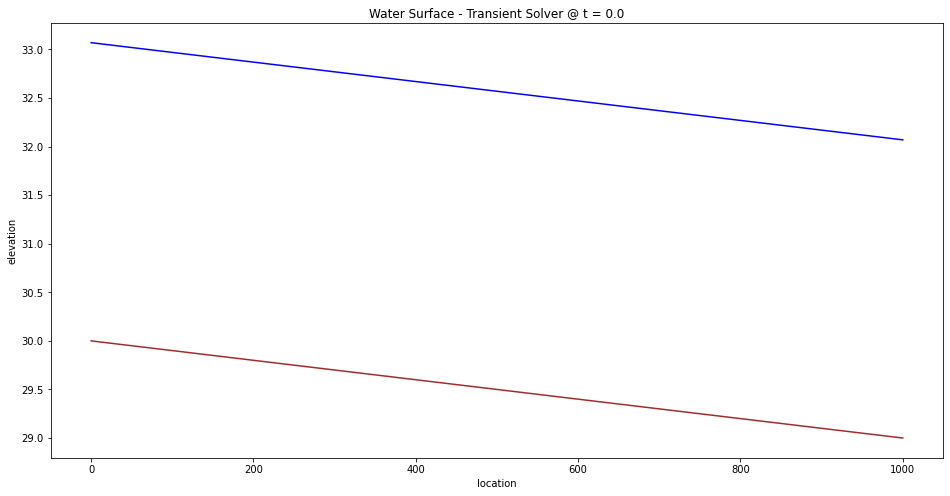

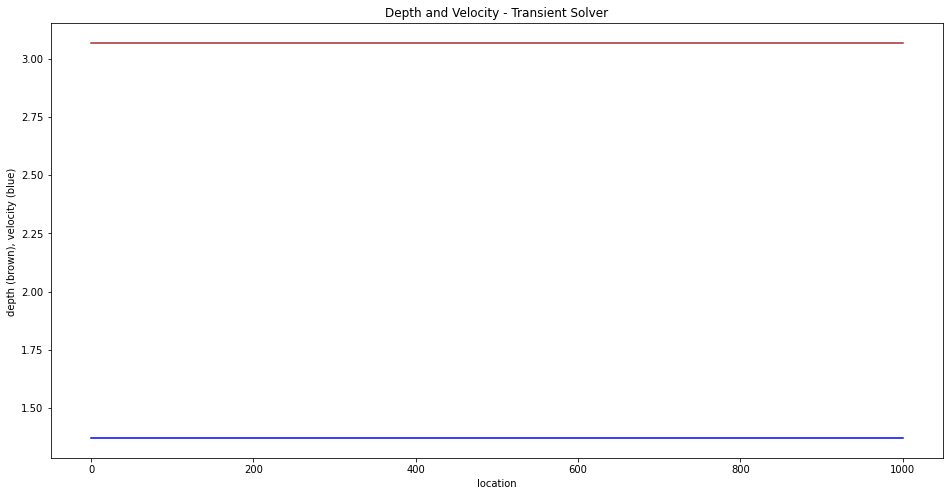

__________
Time =  17750.04298405491  seconds. Time step length =  17.837595591543835  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 0.034
1 3.177 0.006
2 3.285 0.04
3 3.402 0.004
4 3.505 0.03
5 3.622 0.001
6 3.719 0.02
7 3.836 0.0
8 3.928 0.01
9 4.042 0.0
10 4.131 0.0


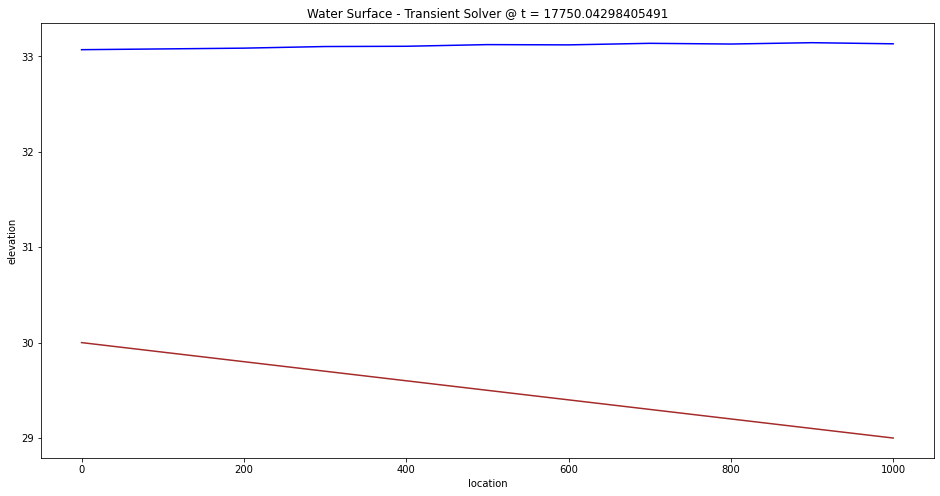

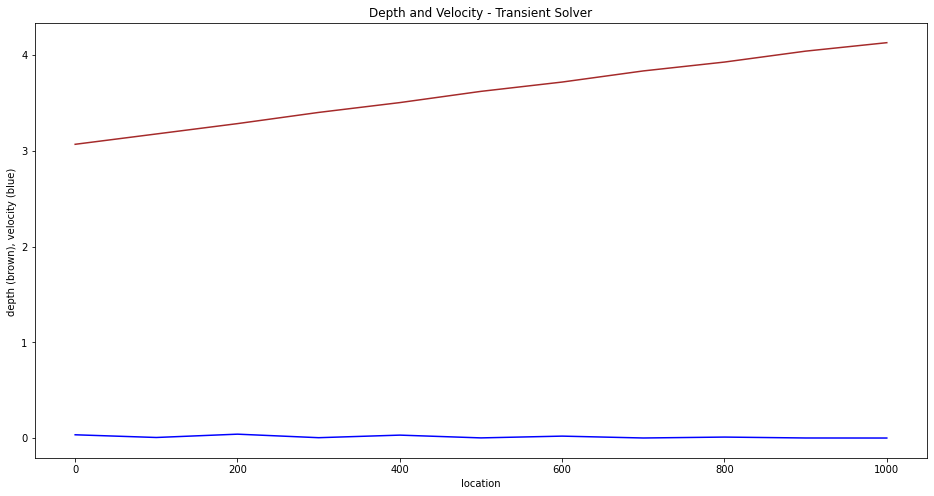

__________
Time =  35732.23617693758  seconds. Time step length =  17.99099963812978  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 0.002
1 3.163 0.024
2 3.263 0.011
3 3.362 0.021
4 3.462 0.009
5 3.561 0.016
6 3.662 0.006
7 3.761 0.01
8 3.862 0.004
9 3.961 0.004
10 4.061 0.0


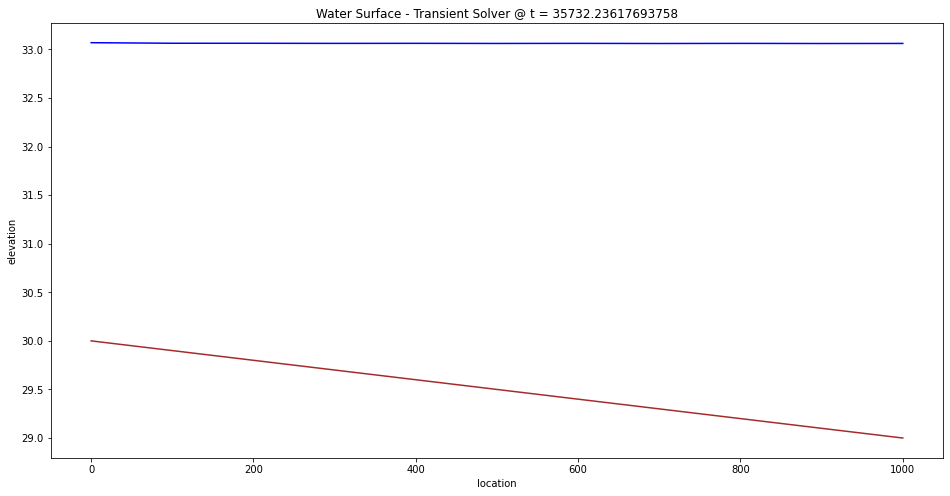

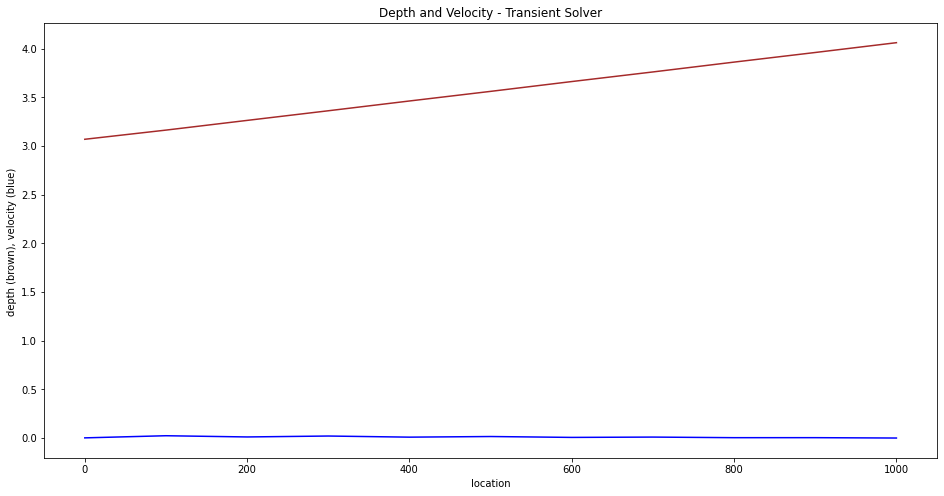

__________
Time =  53714.46557402405  seconds. Time step length =  17.983862049513935  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 -0.002
2 3.263 0.002
3 3.363 -0.001
4 3.463 0.002
5 3.563 -0.001
6 3.663 0.001
7 3.763 -0.0
8 3.863 0.001
9 3.963 0.001
10 4.062 0.0


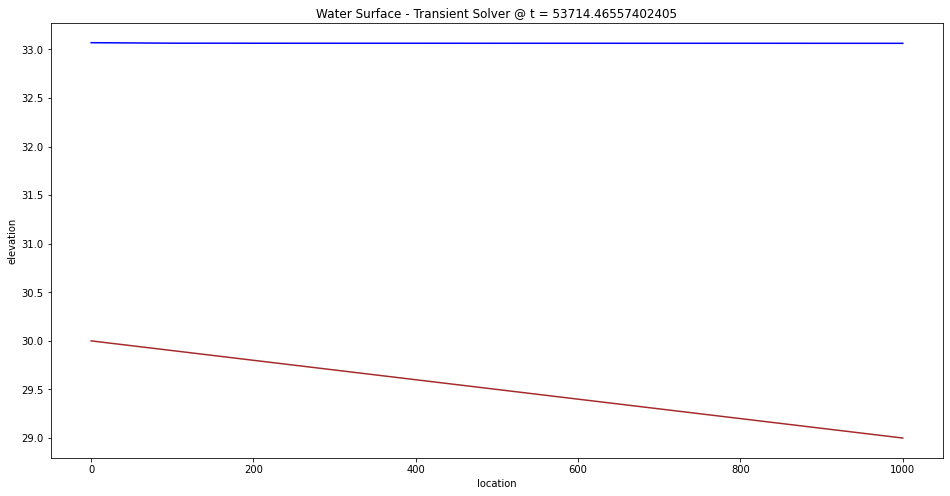

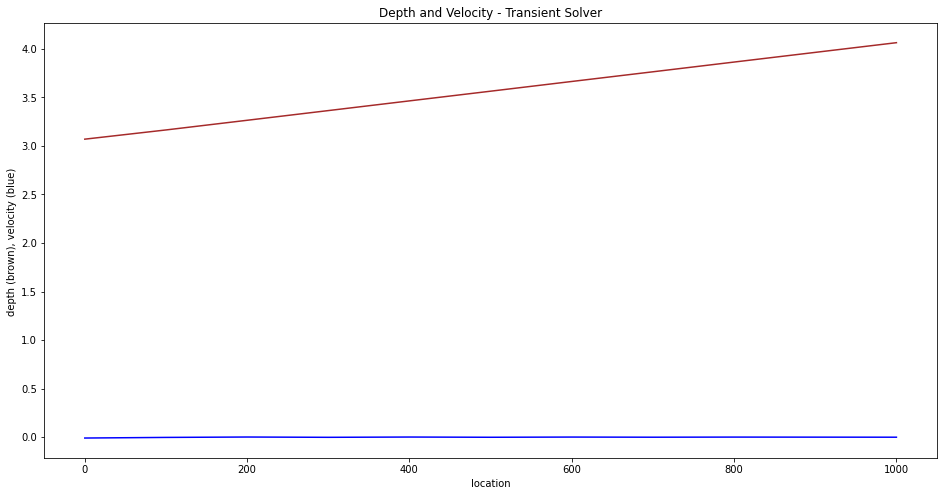

__________
Time =  71696.81028089393  seconds. Time step length =  17.982007240250393  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.01
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


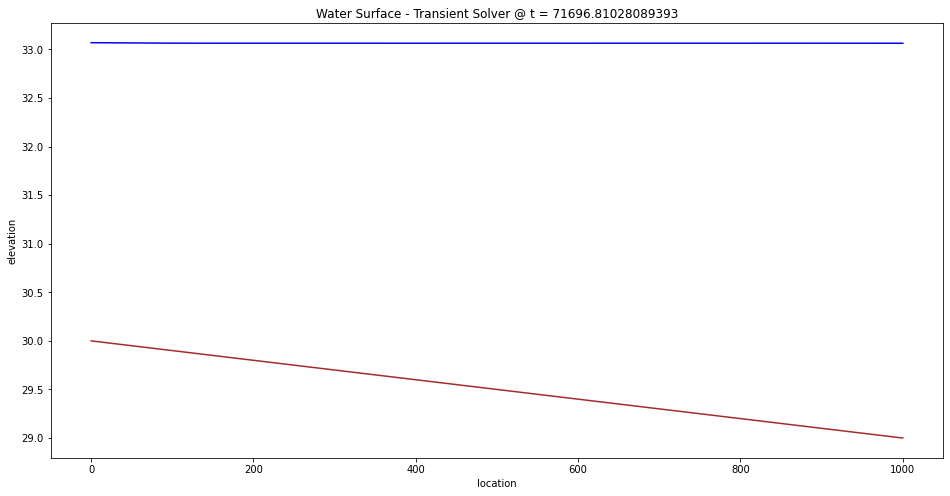

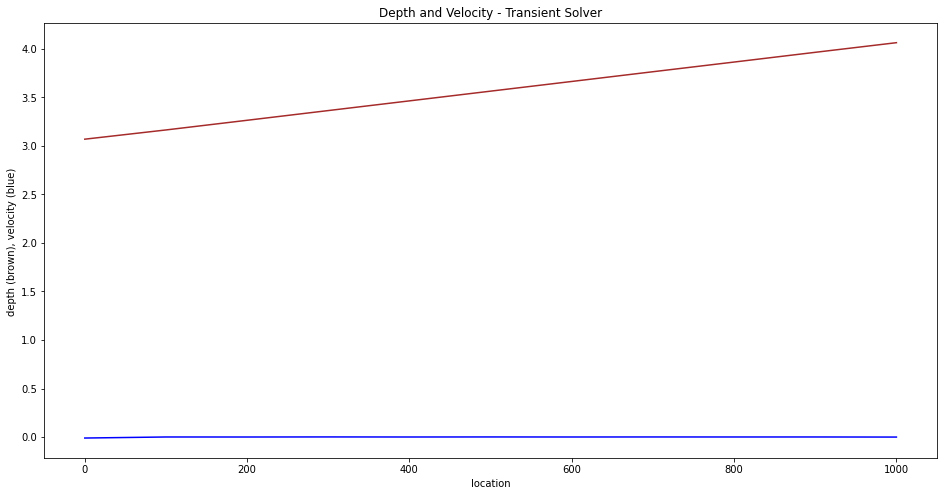

__________
Time =  89679.15080789755  seconds. Time step length =  17.982416329246238  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


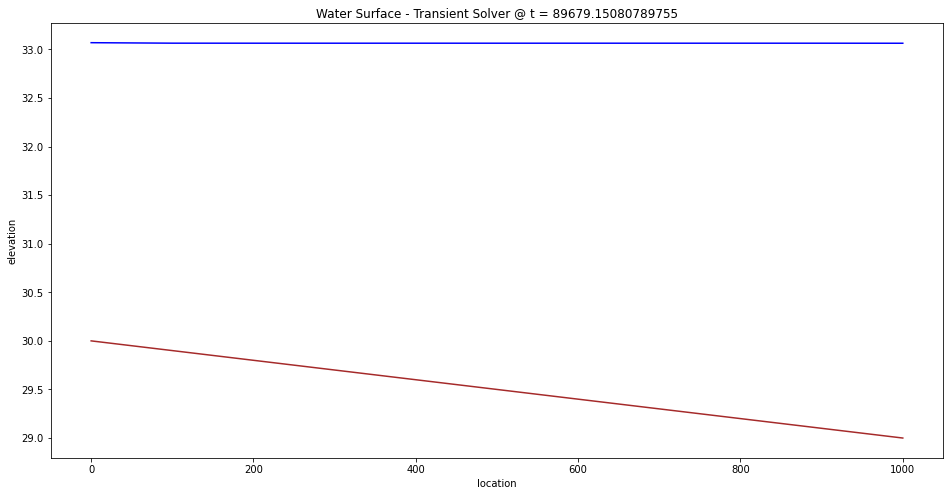

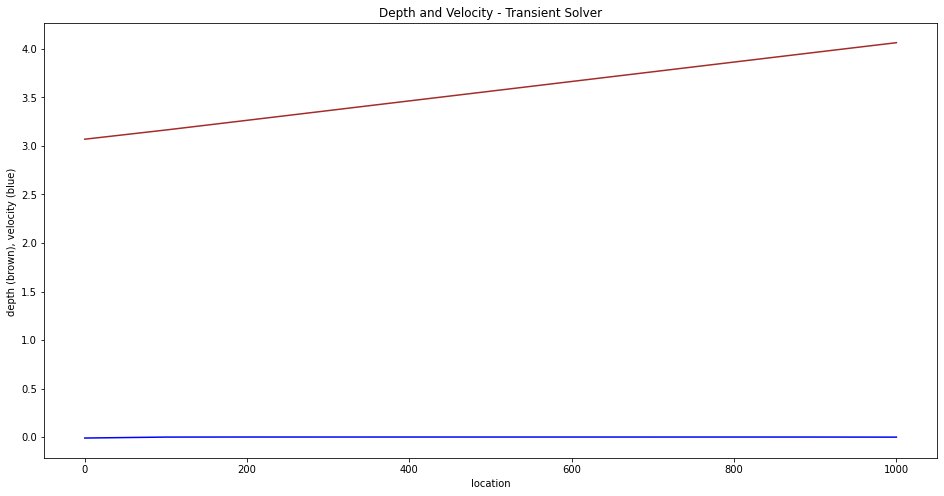

__________
Time =  107661.48980392302  seconds. Time step length =  17.982309253486836  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


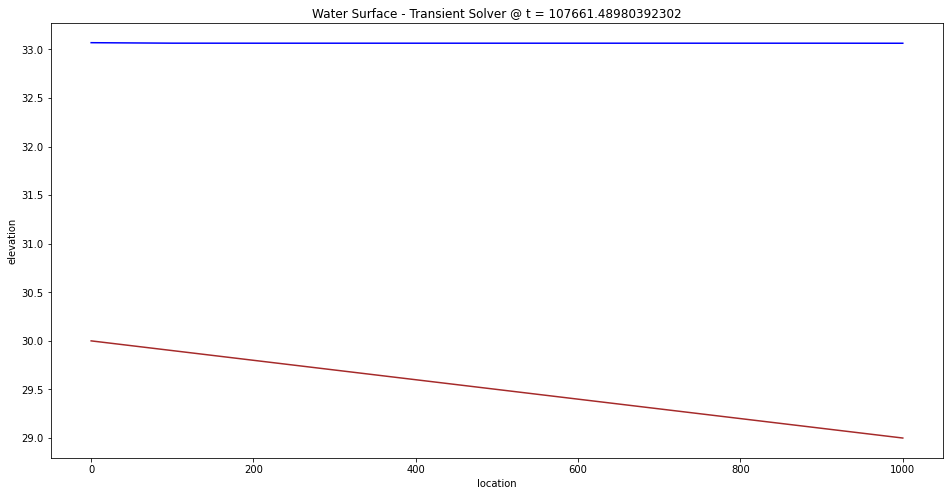

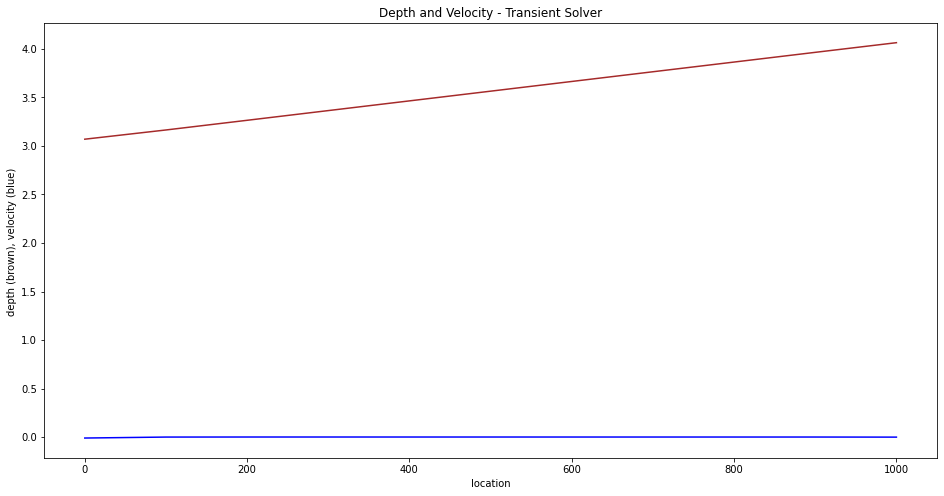

__________
Time =  125643.82899878013  seconds. Time step length =  17.982348995717118  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


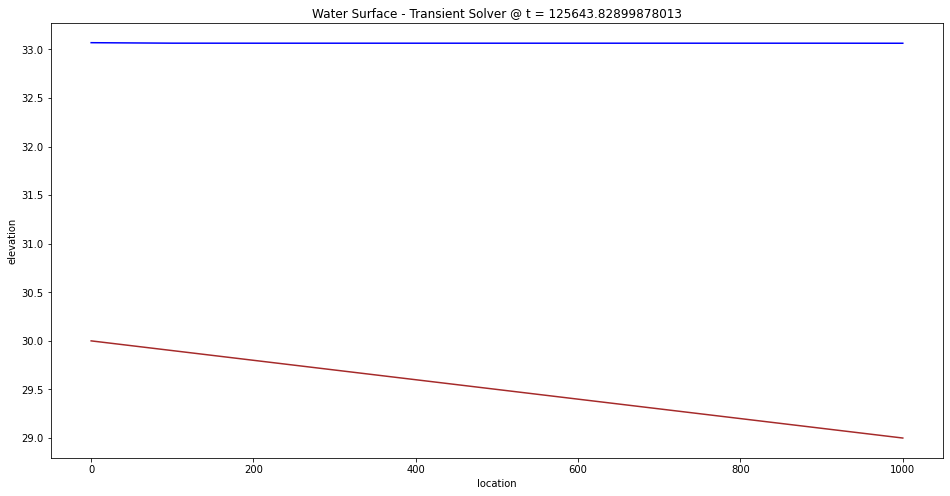

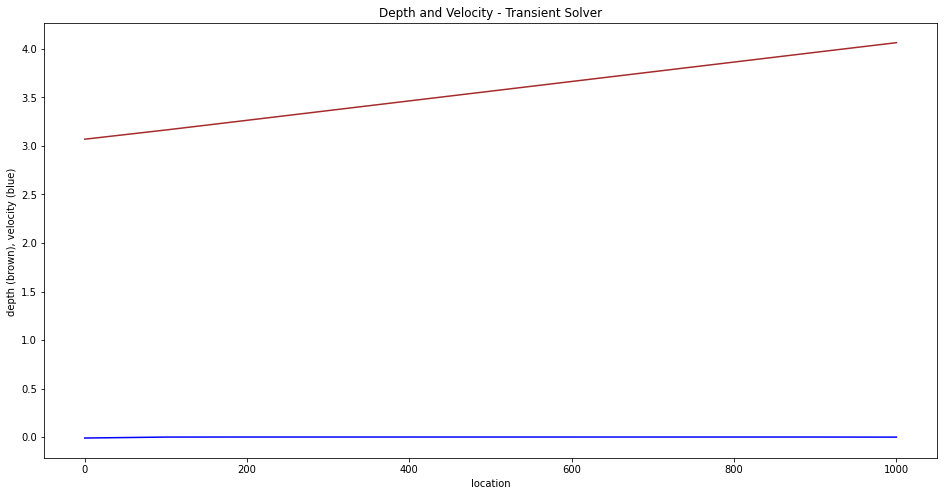

__________
Time =  143626.16817866295  seconds. Time step length =  17.982336633989462  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


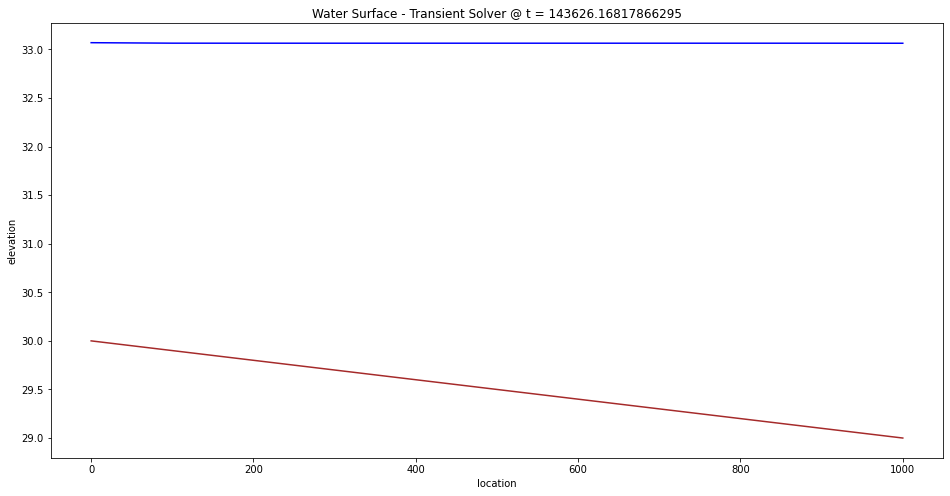

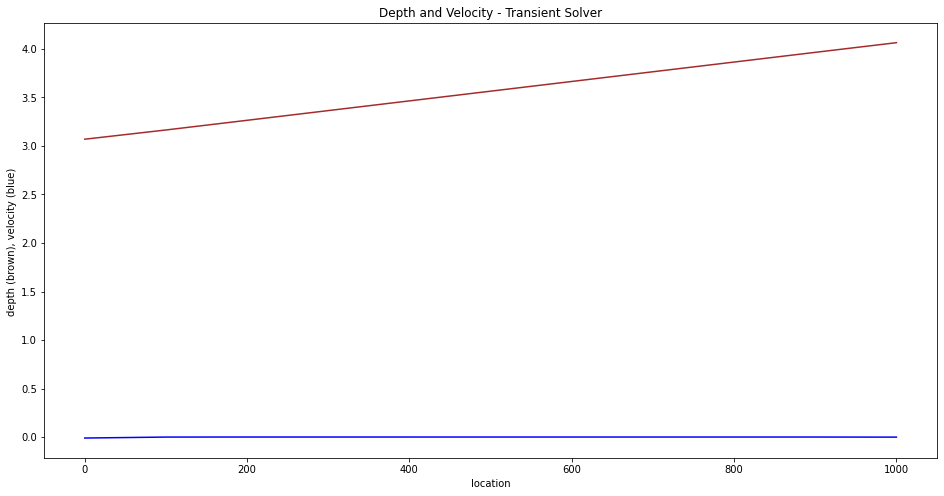

__________
Time =  161608.5073641099  seconds. Time step length =  17.98233972576838  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


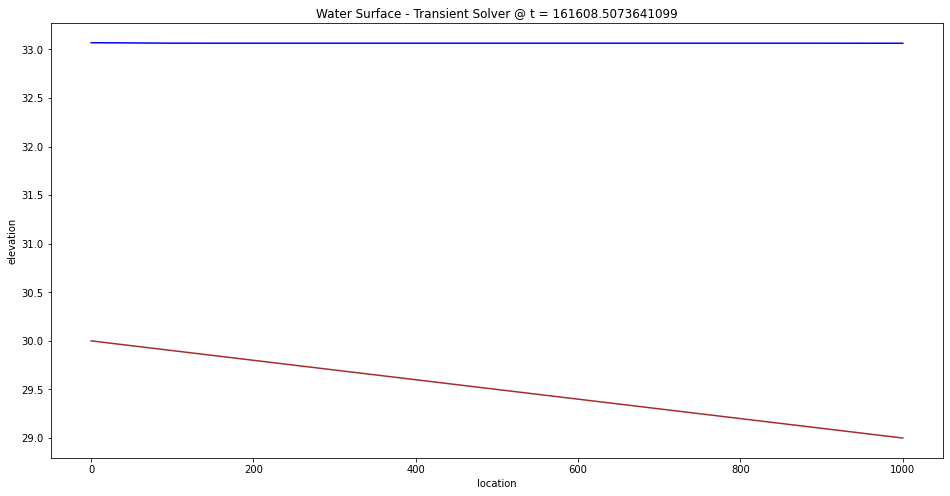

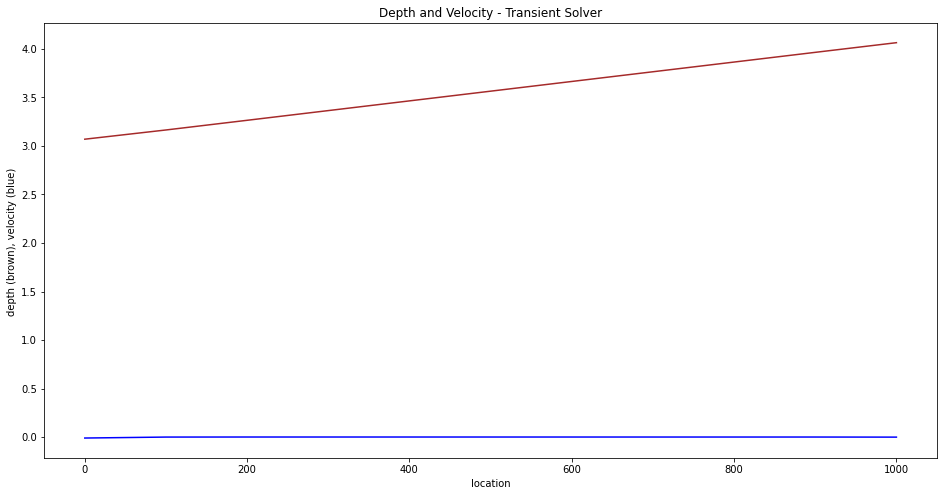

__________
Time =  179590.84654771502  seconds. Time step length =  17.982339100566353  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


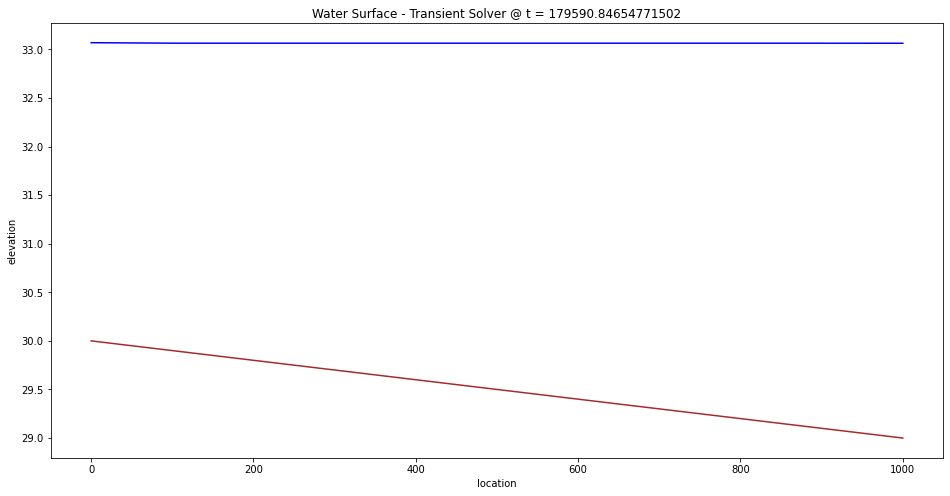

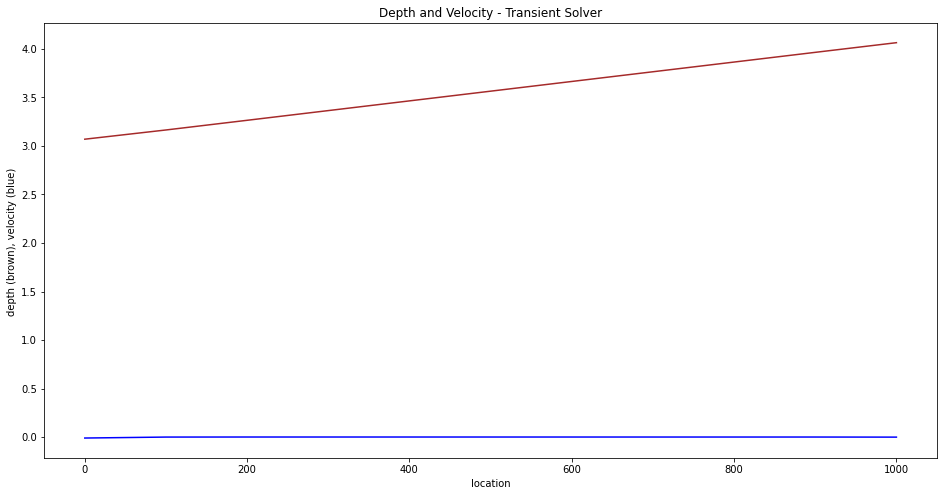

__________
Time =  197573.18573166974  seconds. Time step length =  17.982339184945424  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


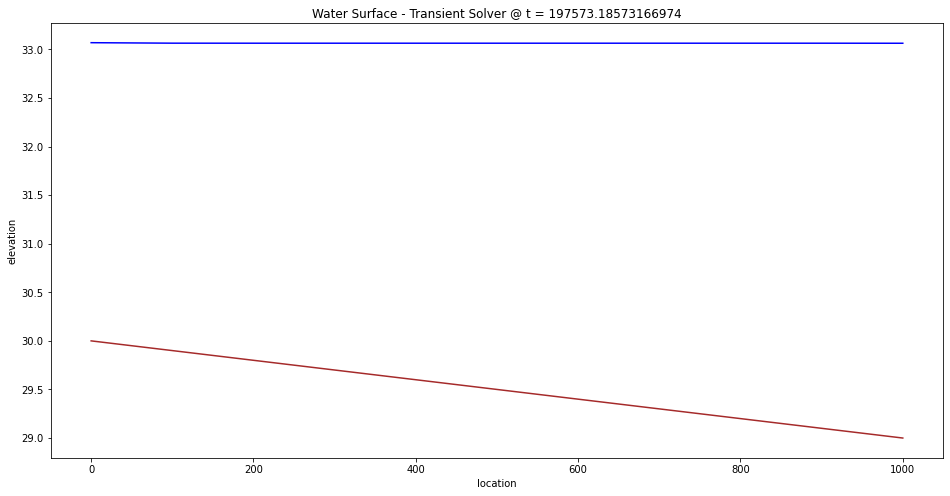

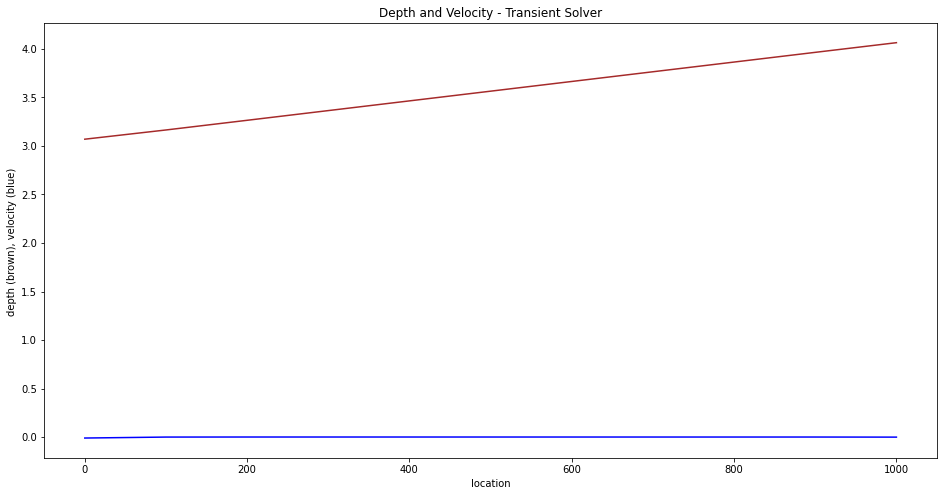

__________
Time =  215555.52491559647  seconds. Time step length =  17.982339189940202  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


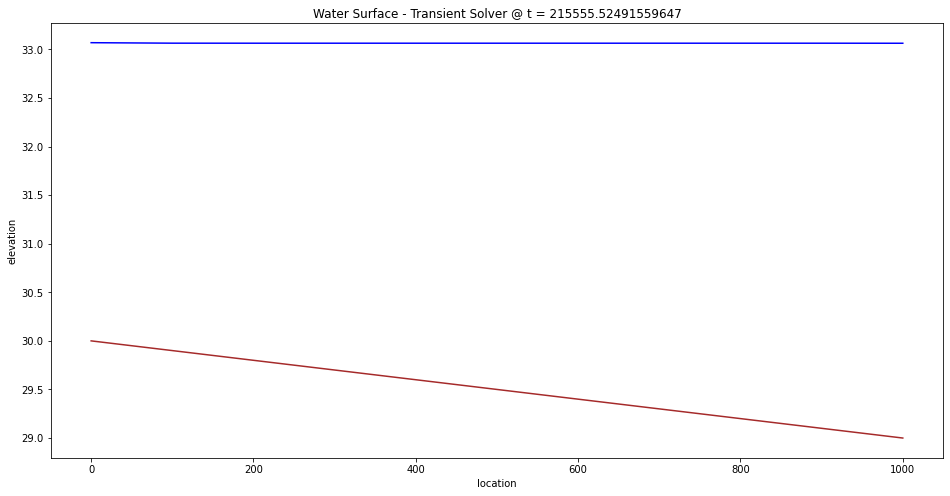

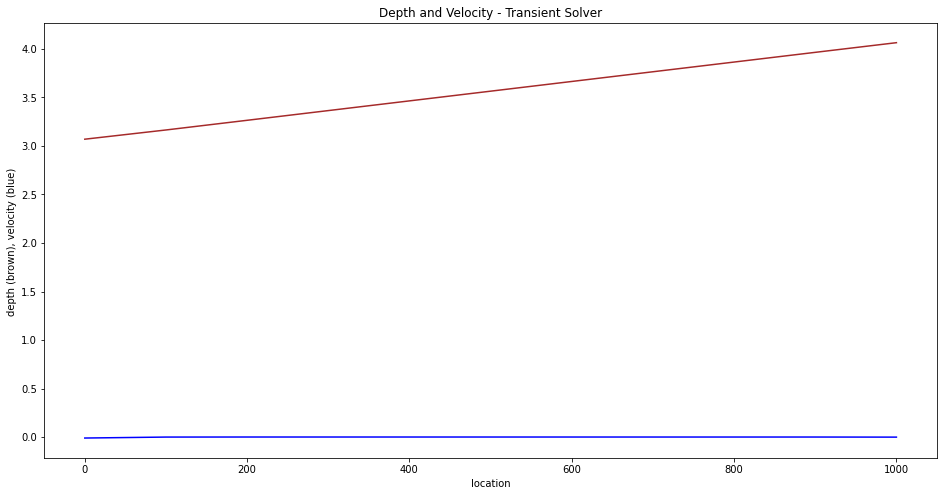

__________
Time =  233537.86409951234  seconds. Time step length =  17.982339180713346  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


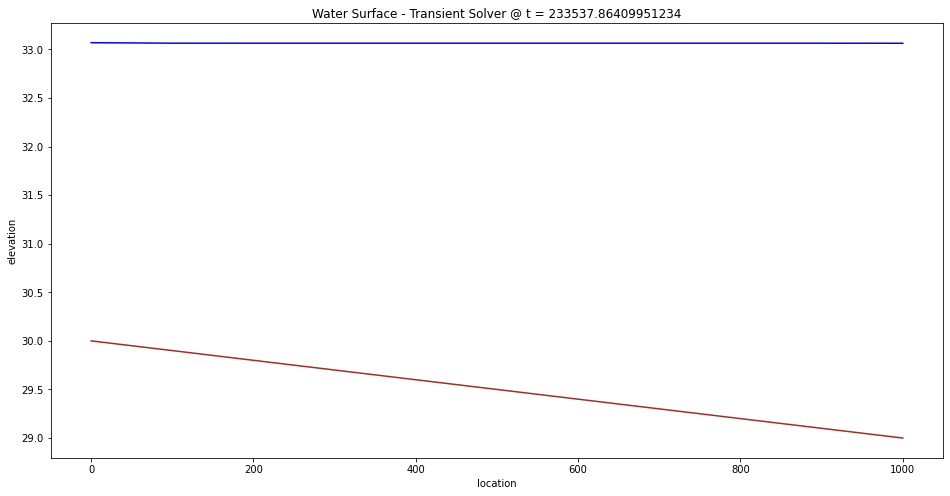

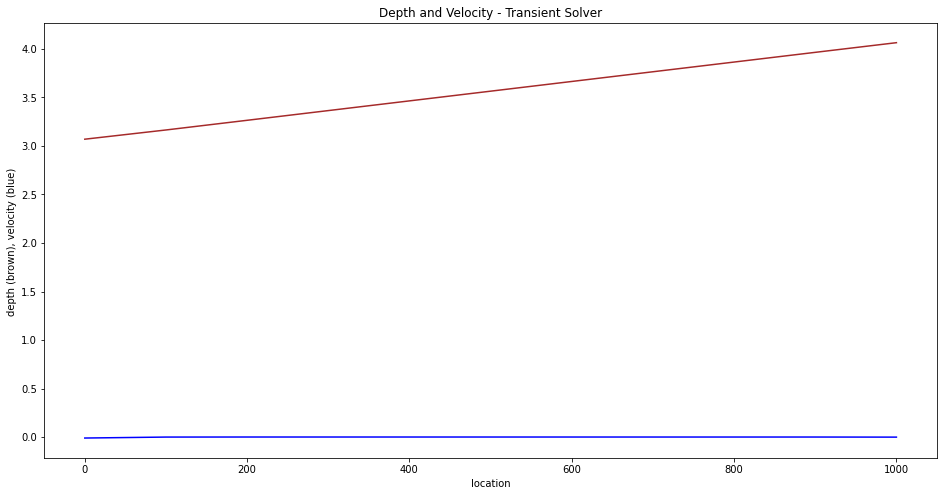

__________
Time =  251520.2032834359  seconds. Time step length =  17.9823391851135  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


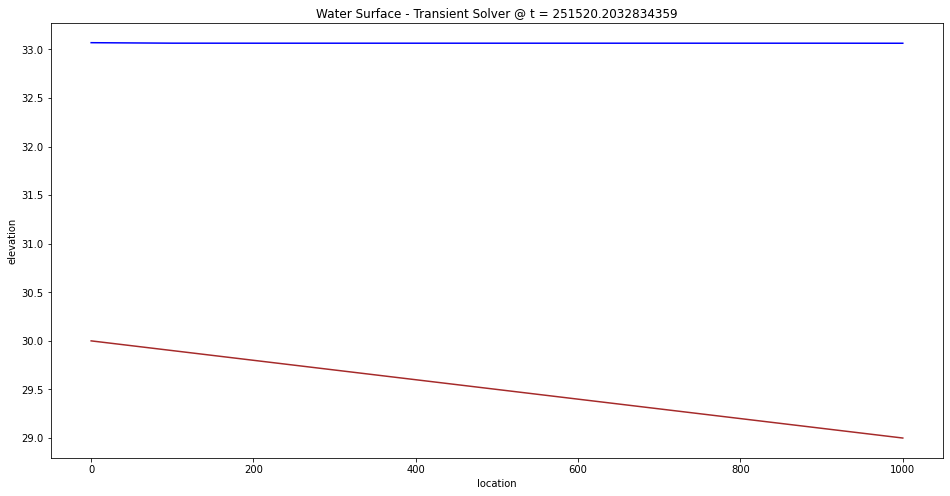

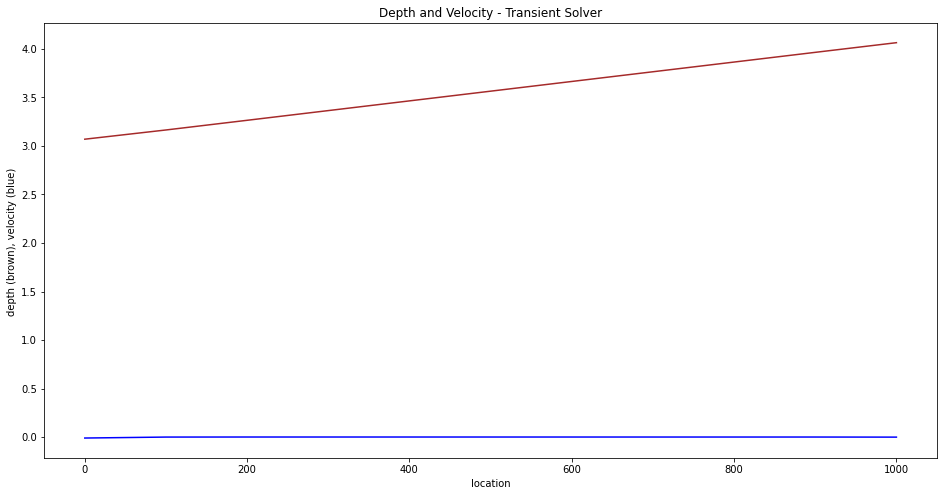

__________
Time =  269502.54246735567  seconds. Time step length =  17.982339183553623  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


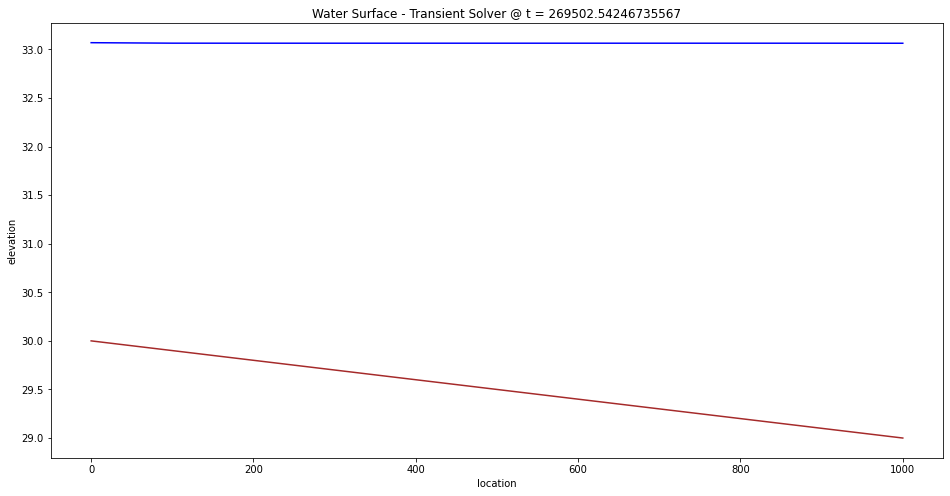

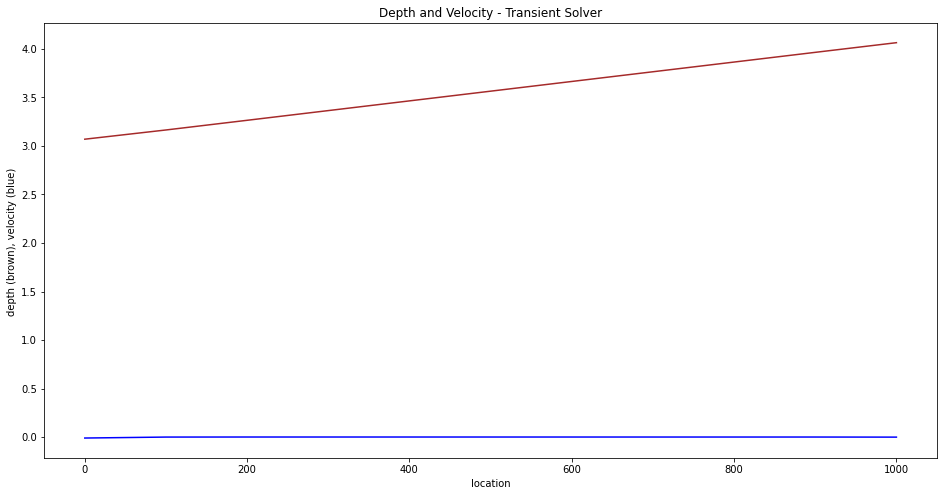

__________
Time =  287484.881651277  seconds. Time step length =  17.982339184018095  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


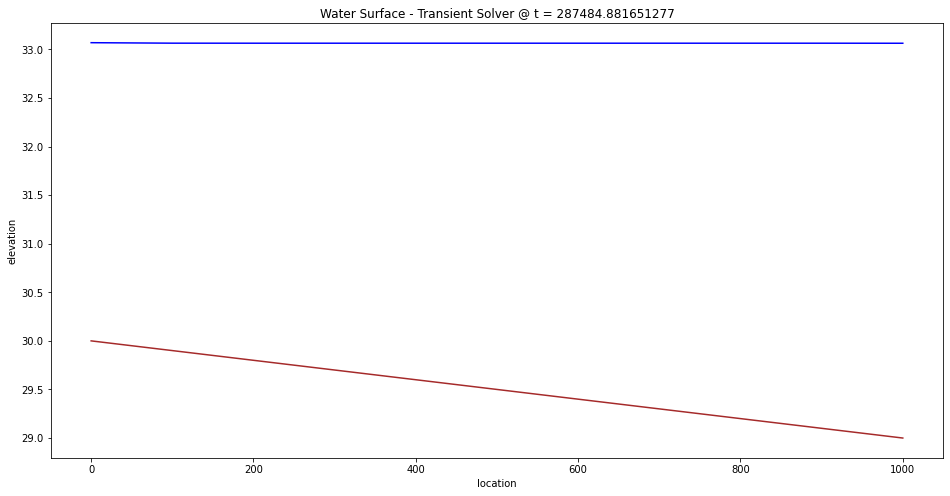

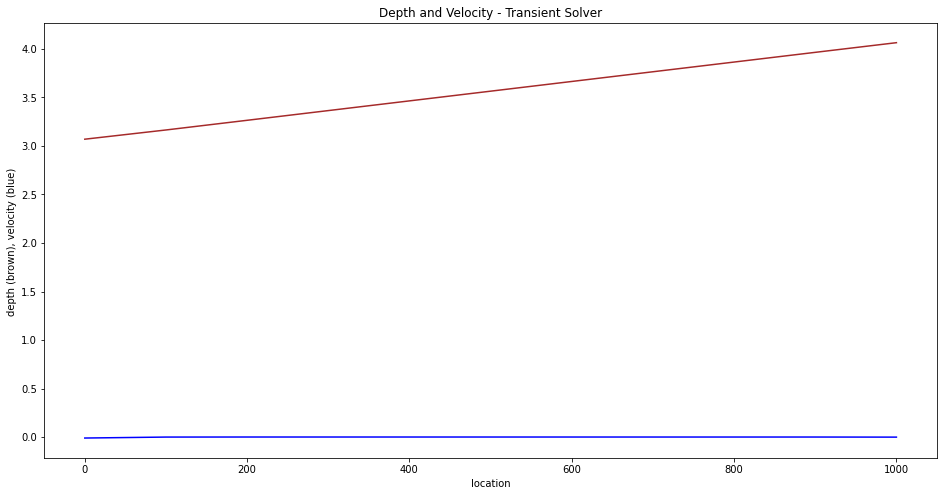

__________
Time =  305467.2208351995  seconds. Time step length =  17.982339183899345  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


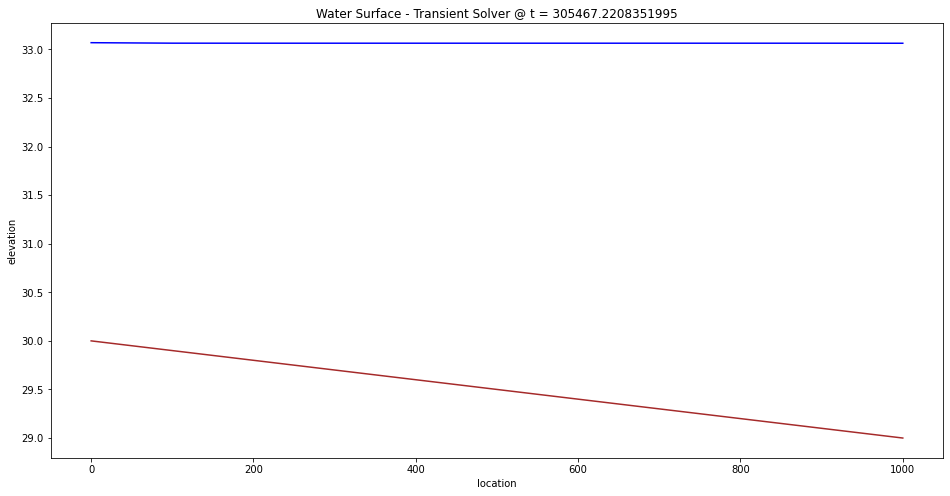

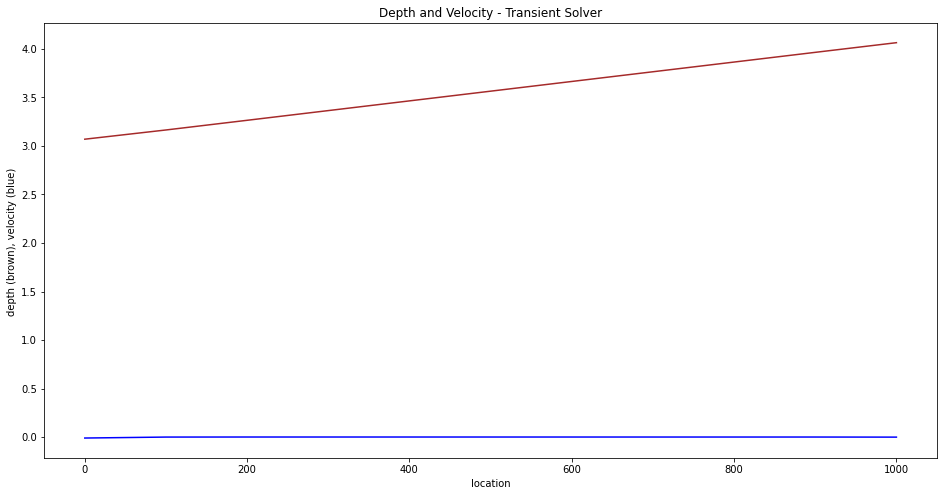

__________
Time =  323449.5600191167  seconds. Time step length =  17.982339183924555  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


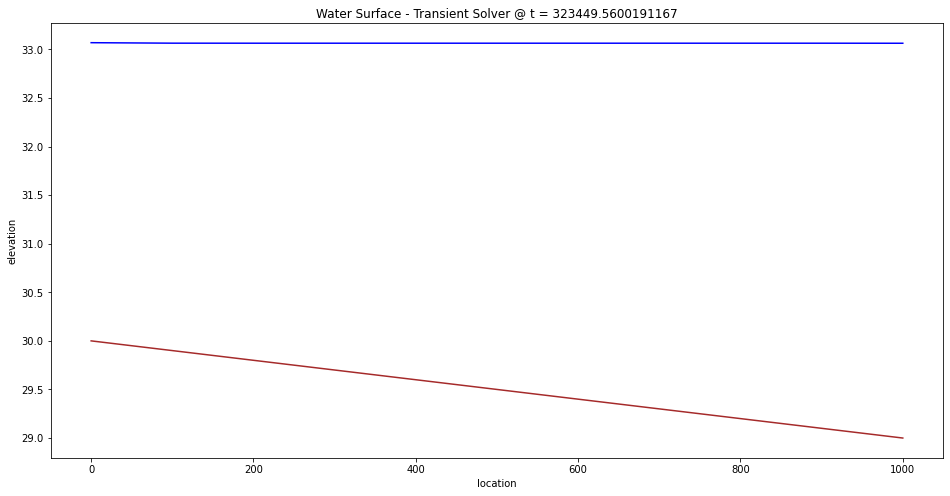

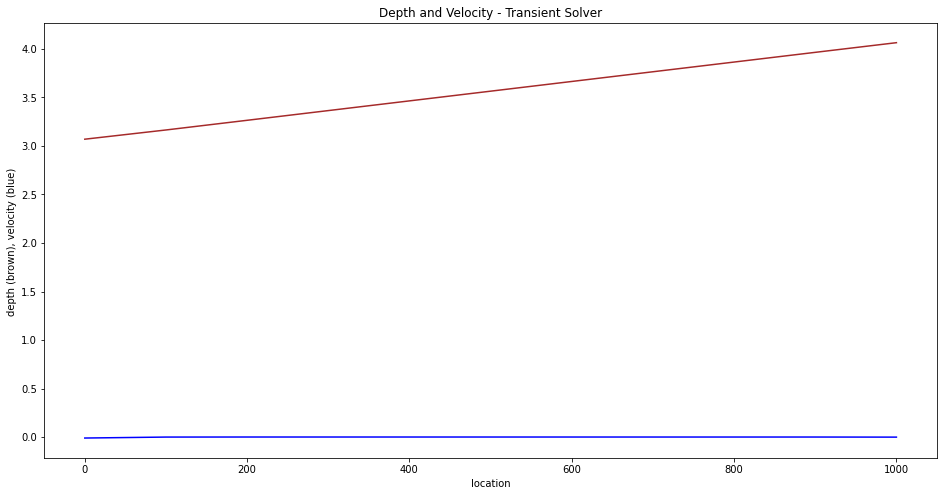

__________
Time =  341431.899203033  seconds. Time step length =  17.98233918392078  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


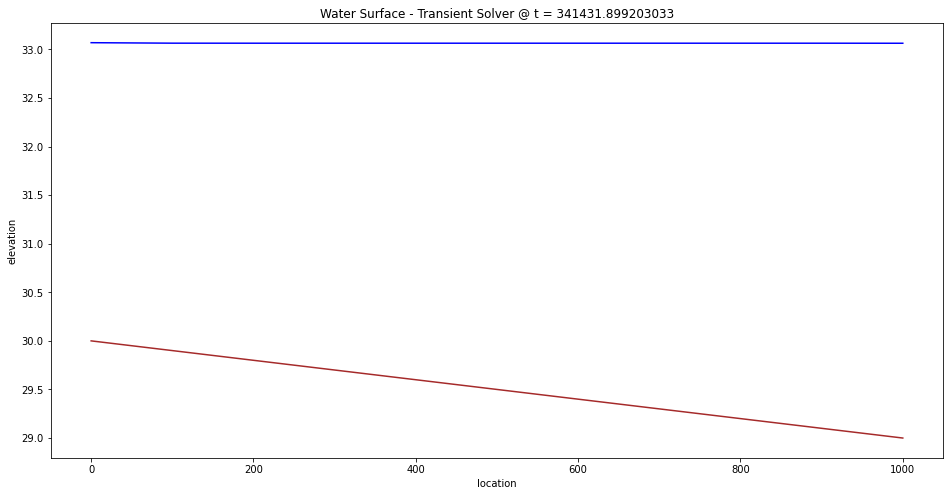

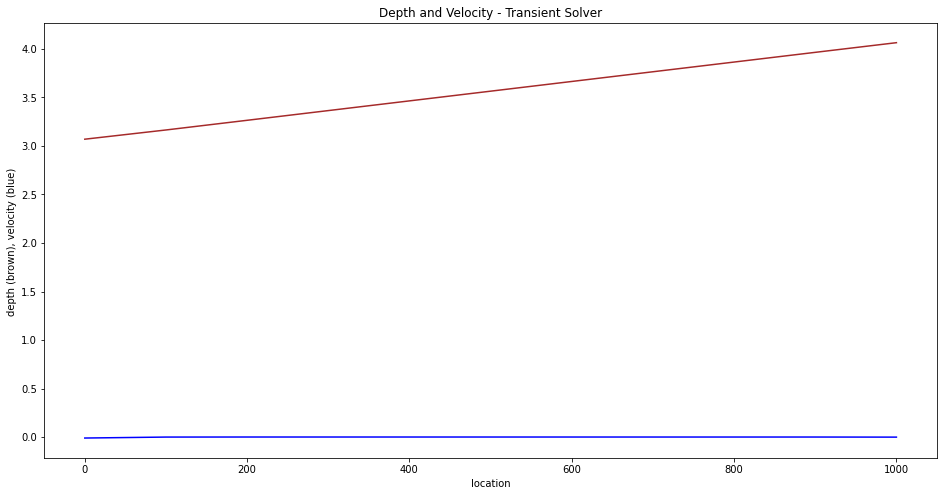

__________
Time =  359414.23838694935  seconds. Time step length =  17.982339183920764  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


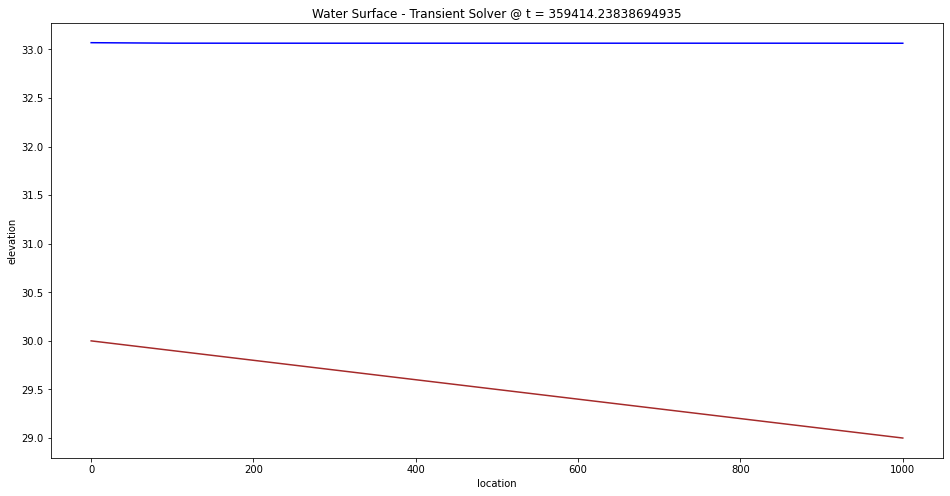

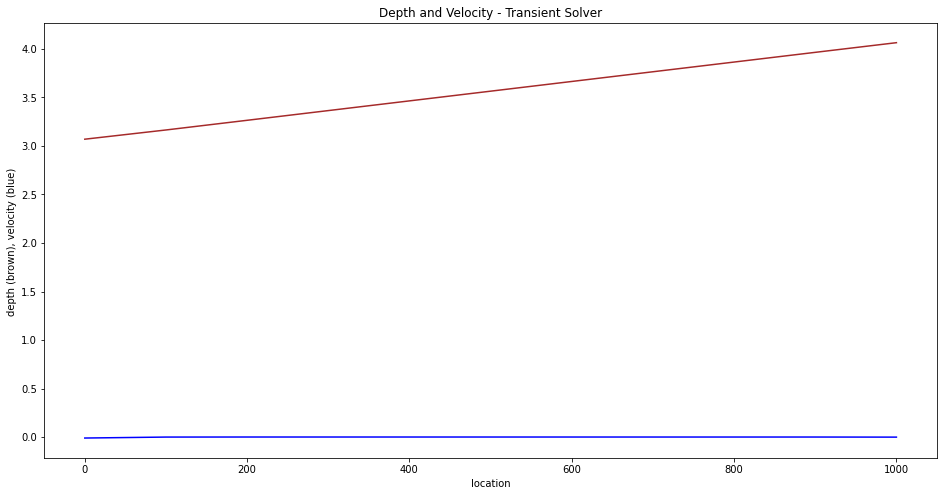

__________
Time =  377396.5775708657  seconds. Time step length =  17.98233918392106  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


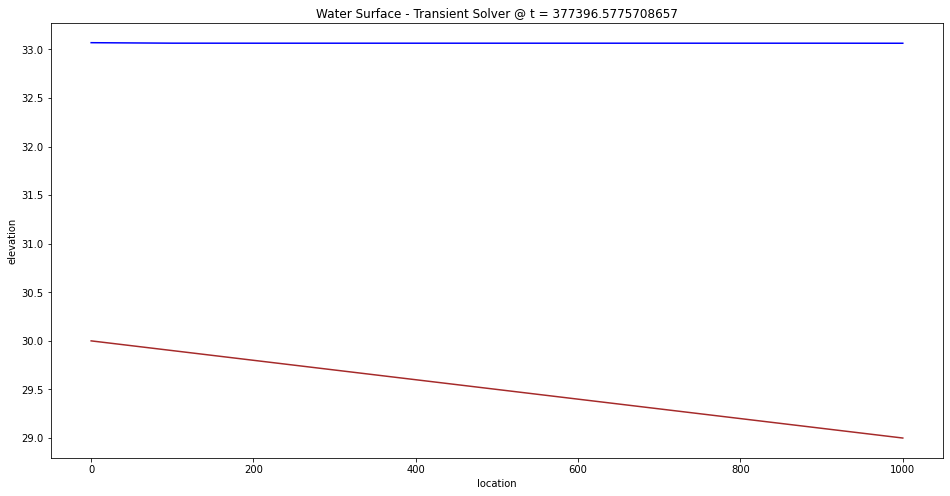

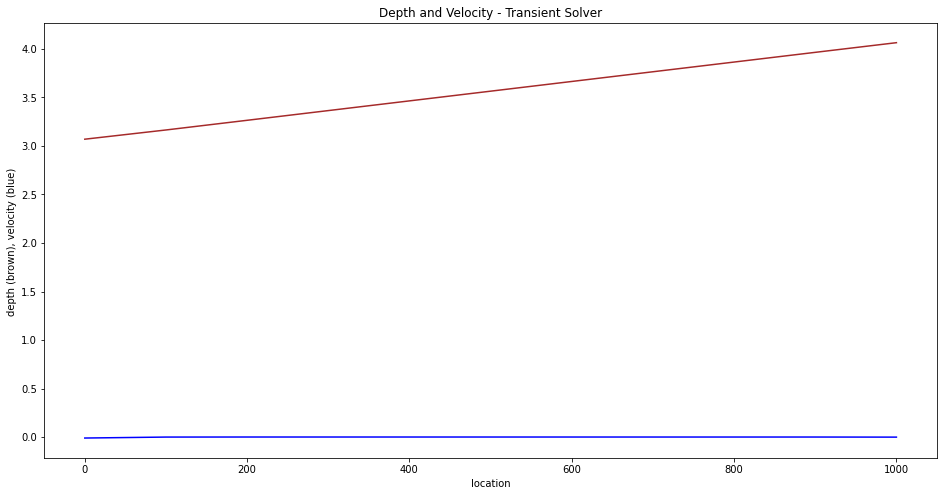

__________
Time =  395378.916754782  seconds. Time step length =  17.98233918392093  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


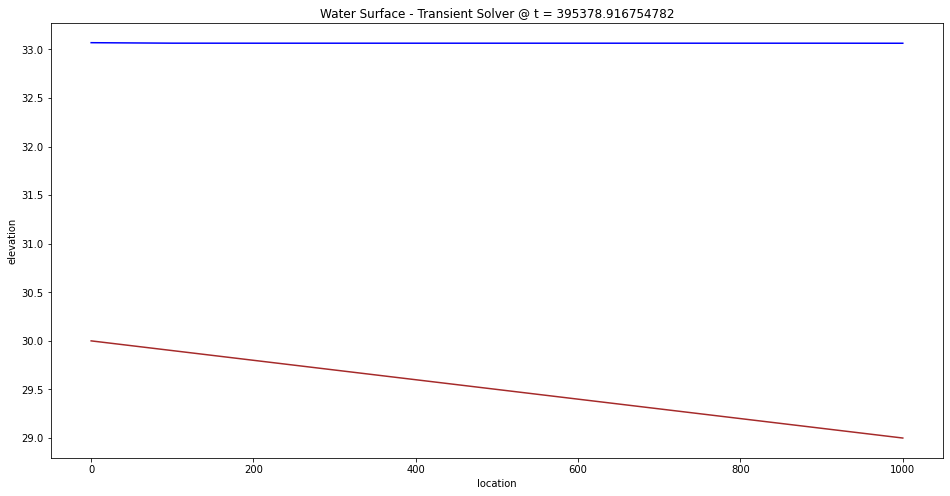

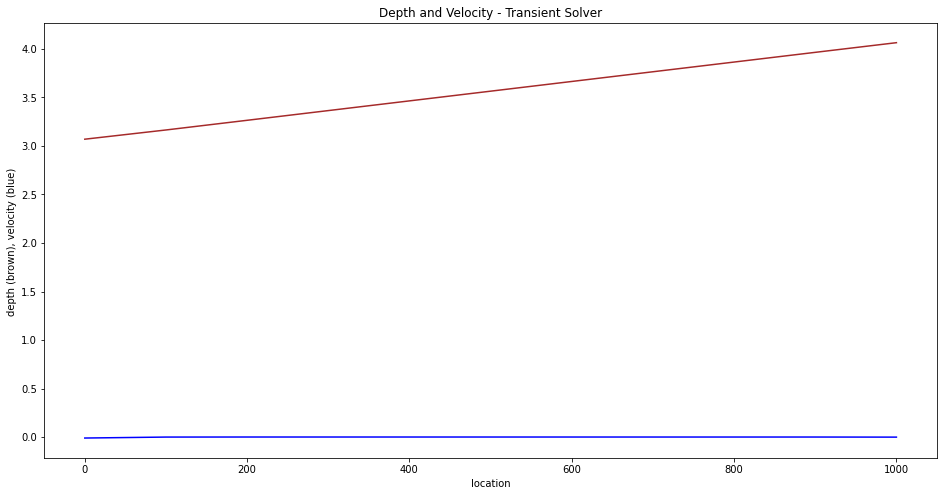

__________
Time =  413361.25593869836  seconds. Time step length =  17.982339183920963  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


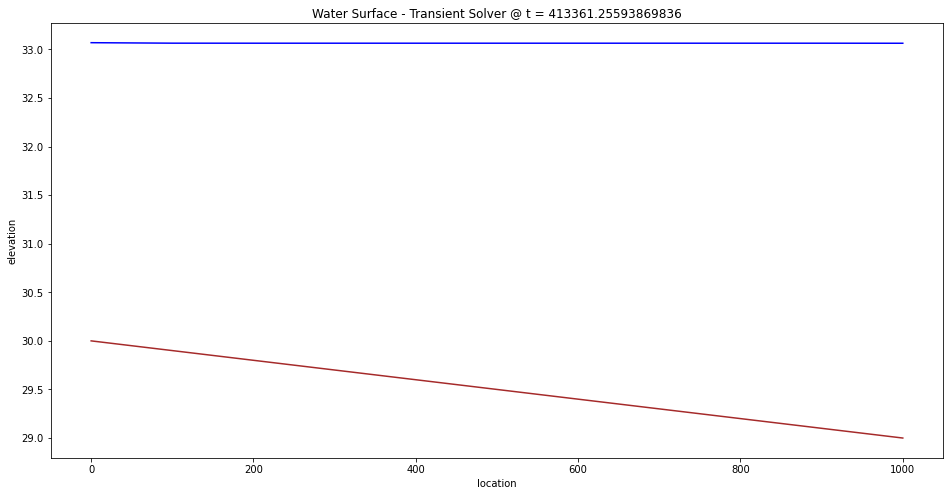

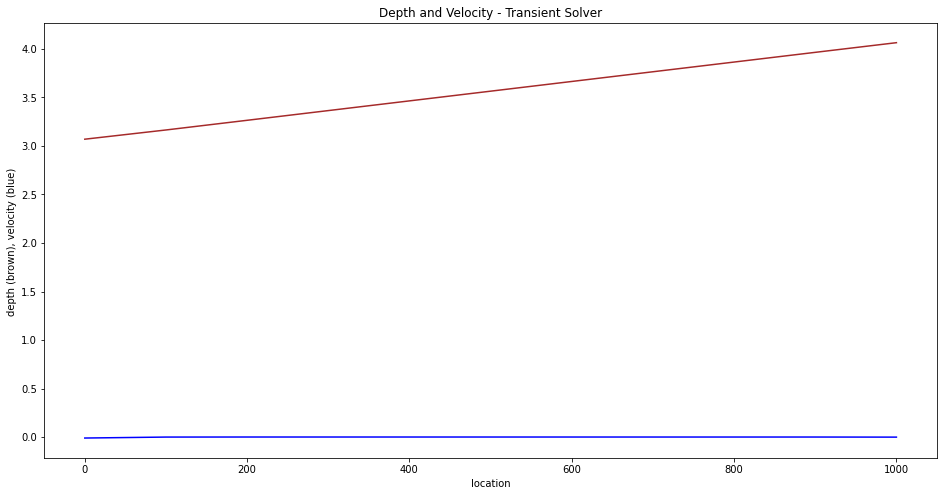

__________
Time =  431343.5951226147  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


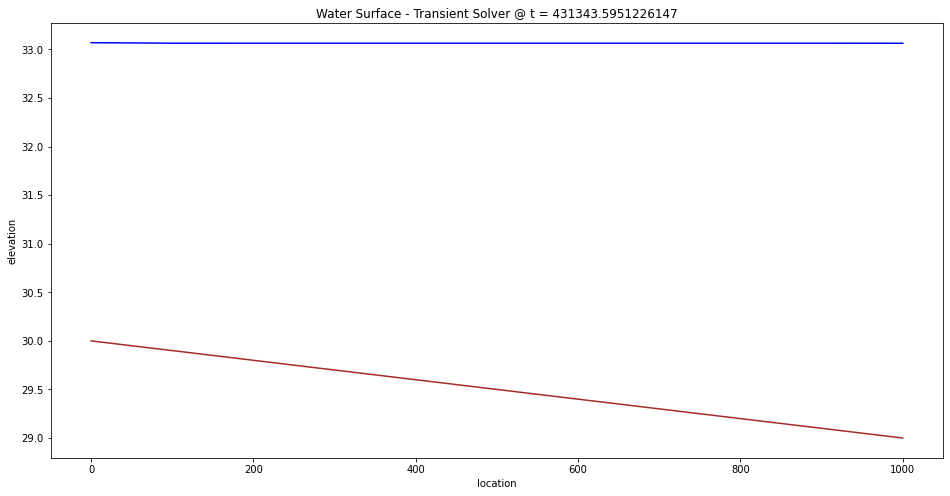

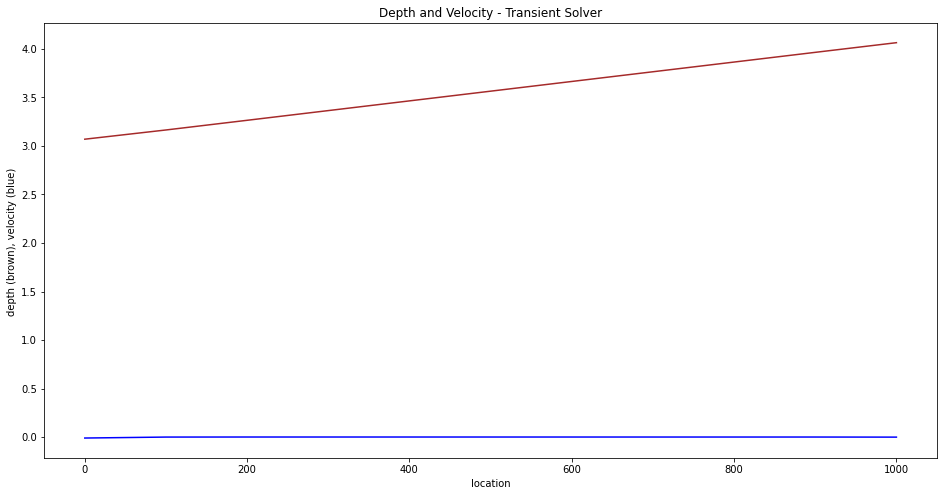

__________
Time =  449325.93430653104  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


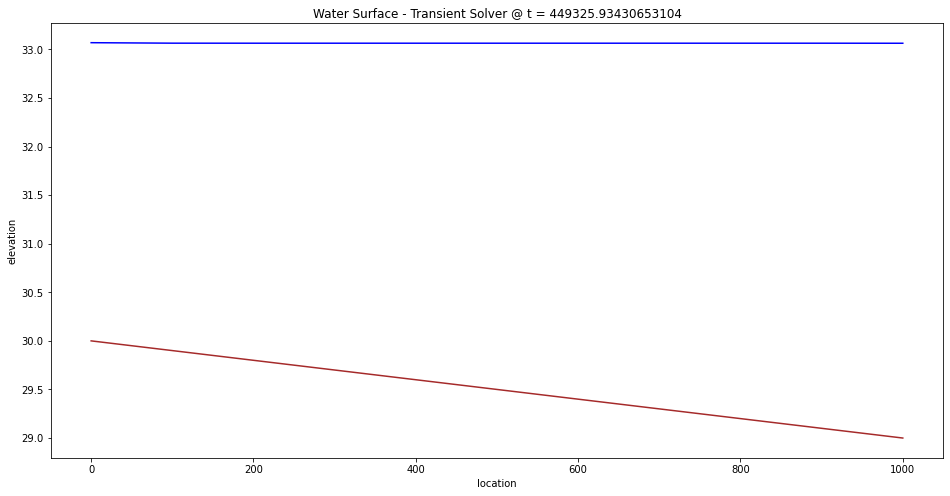

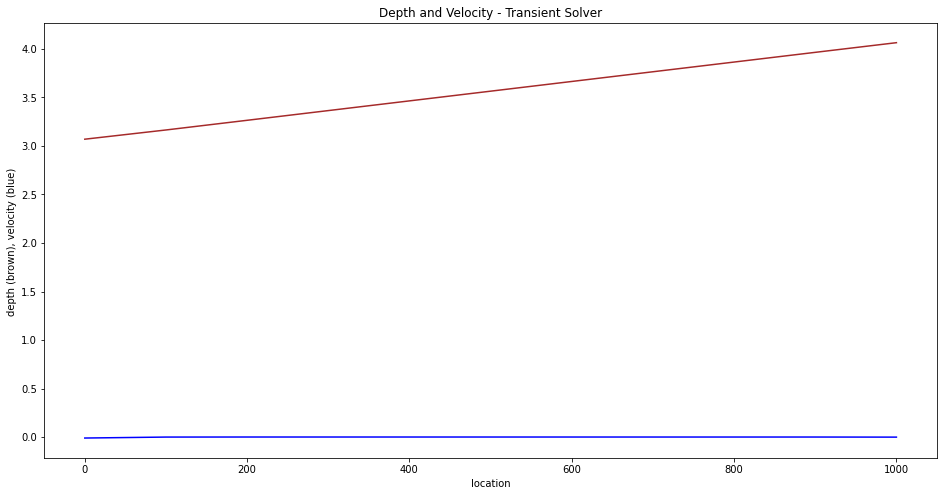

__________
Time =  467308.2734904474  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


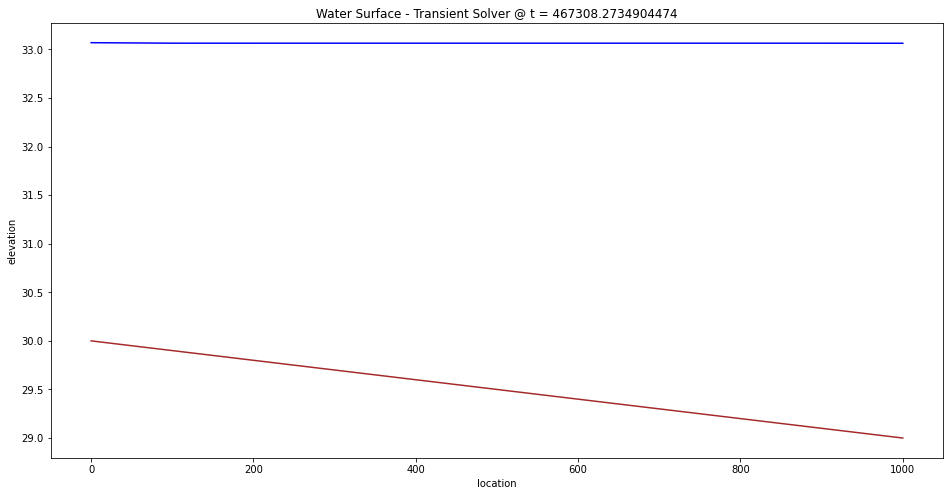

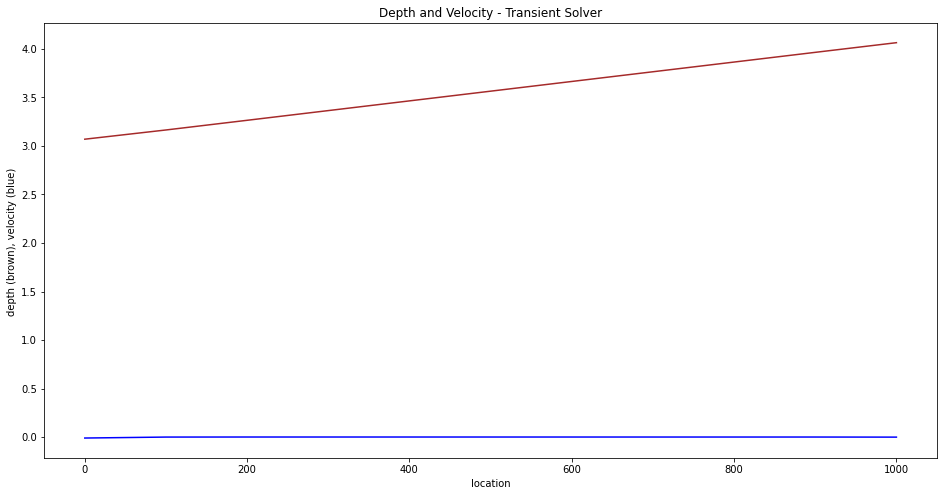

__________
Time =  485290.6126743637  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


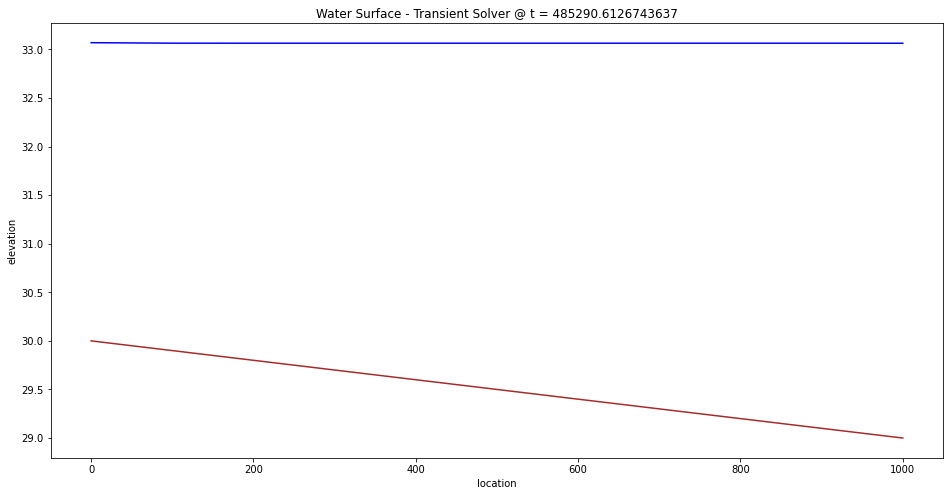

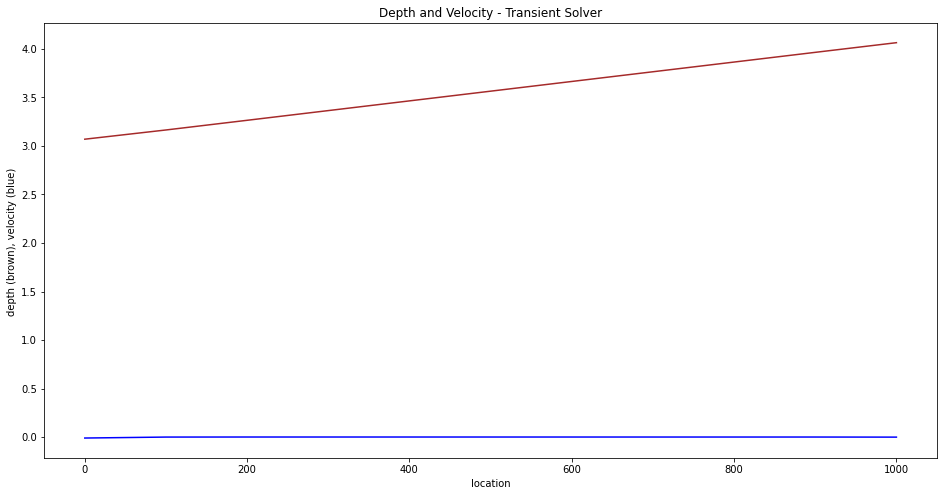

__________
Time =  503272.95185828005  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


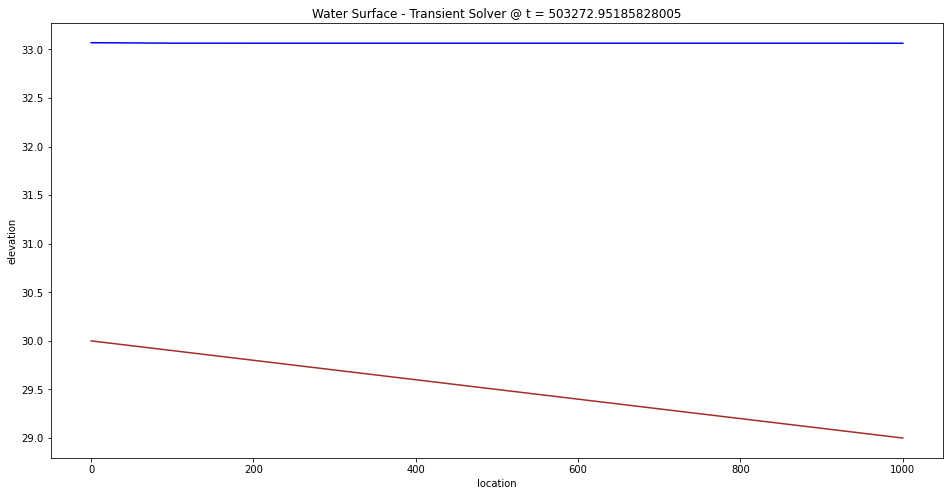

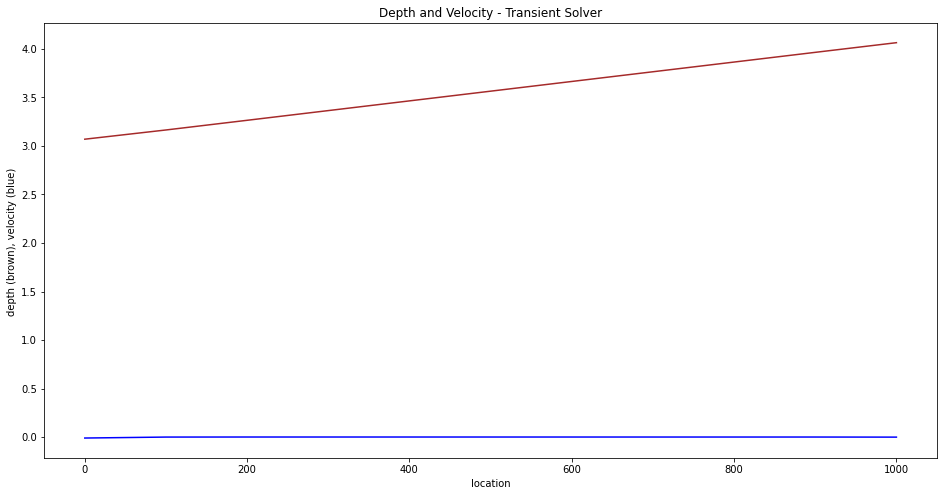

__________
Time =  521255.2910421964  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


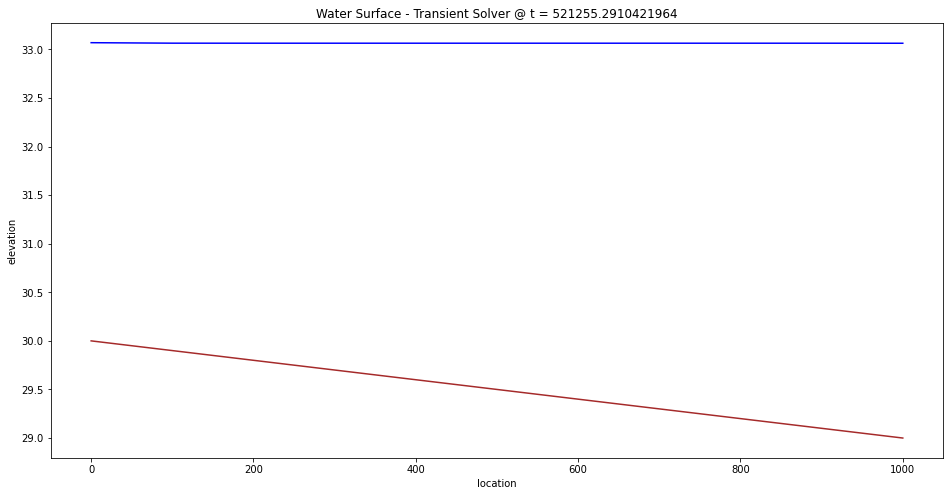

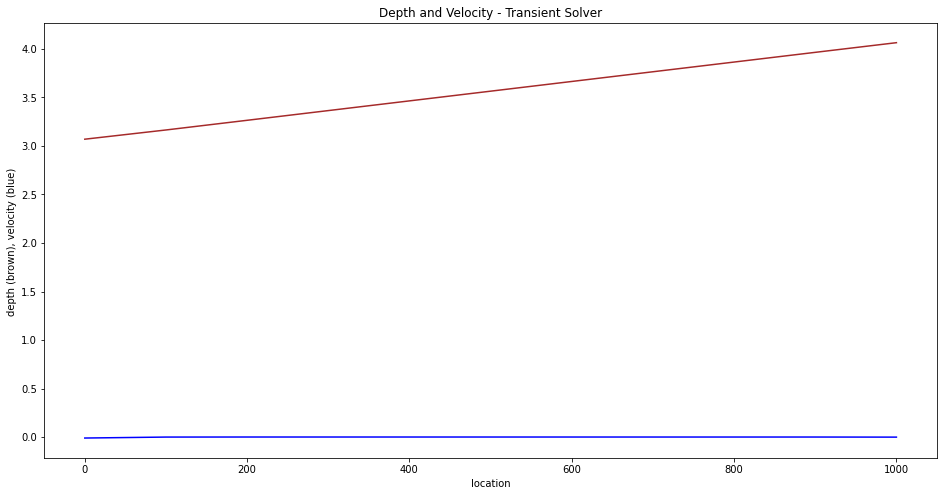

__________
Time =  539237.6302261128  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


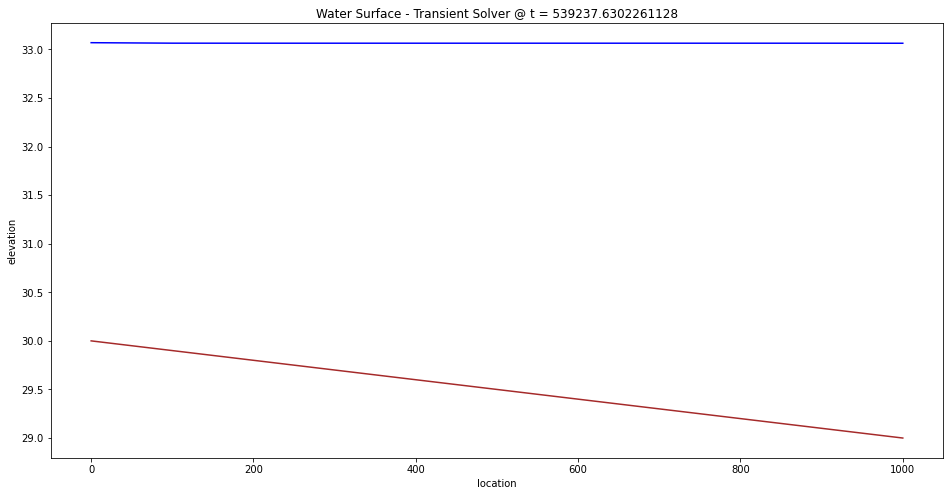

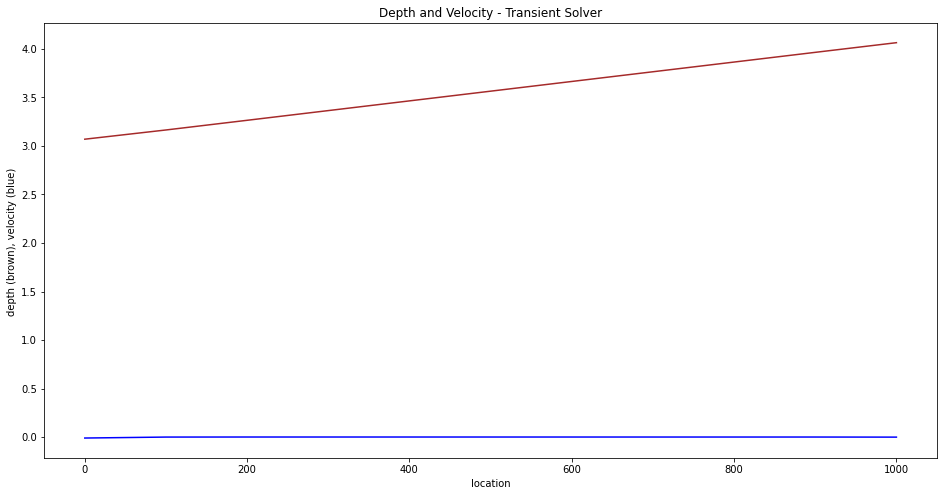

__________
Time =  557219.9694100291  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


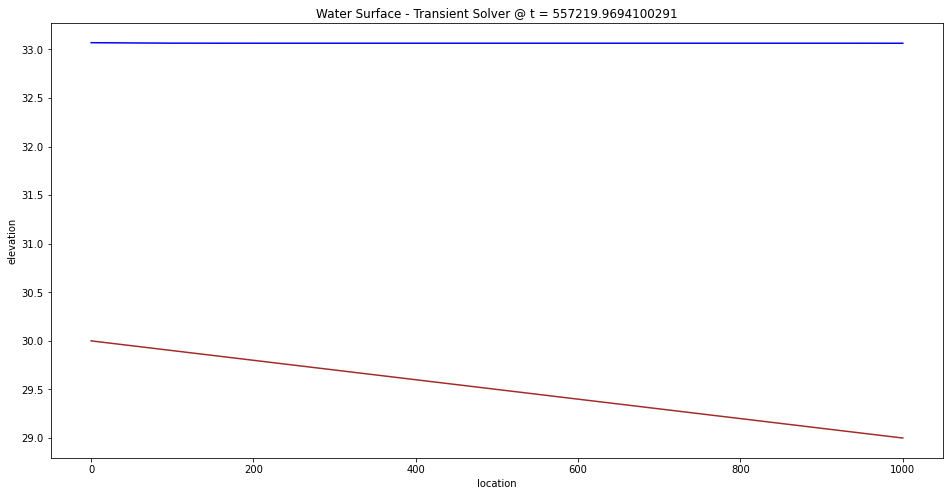

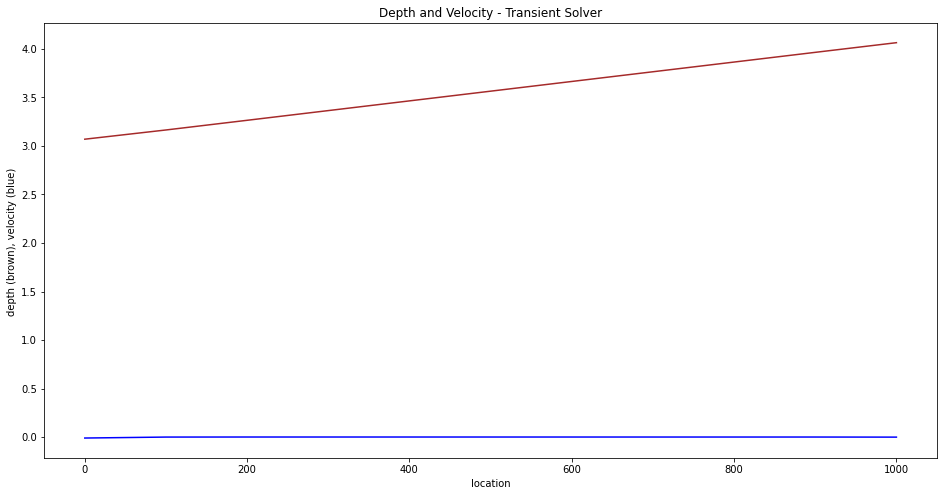

__________
Time =  575202.3085939455  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


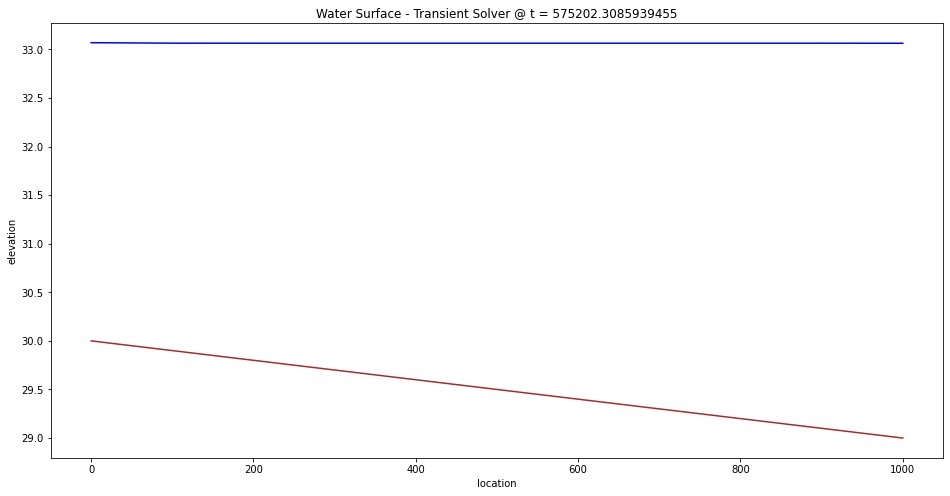

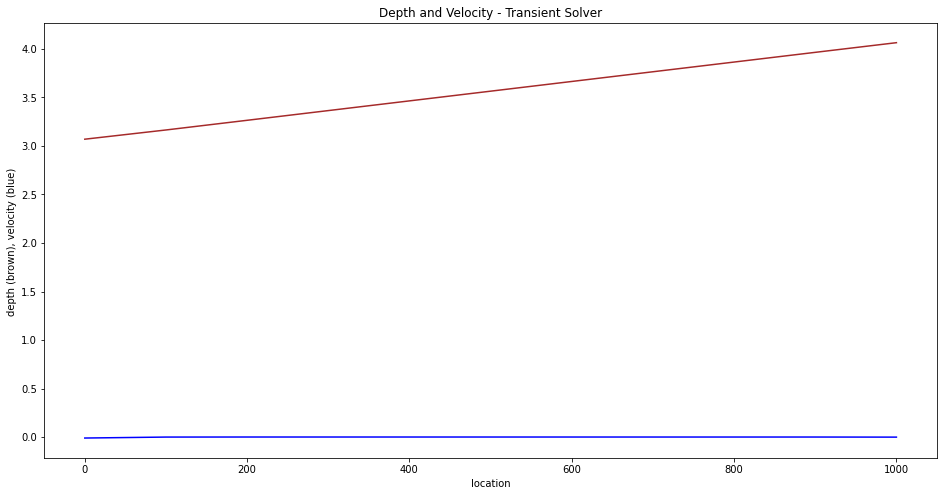

__________
Time =  593184.6477778618  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


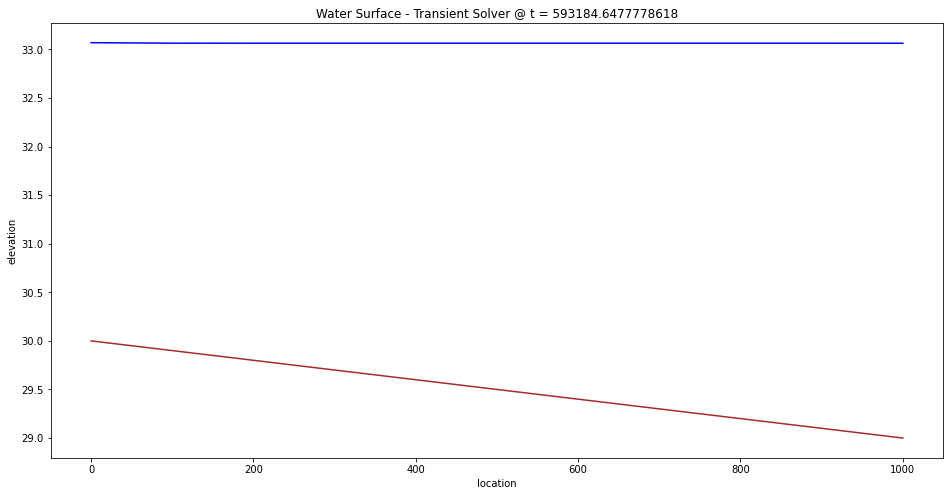

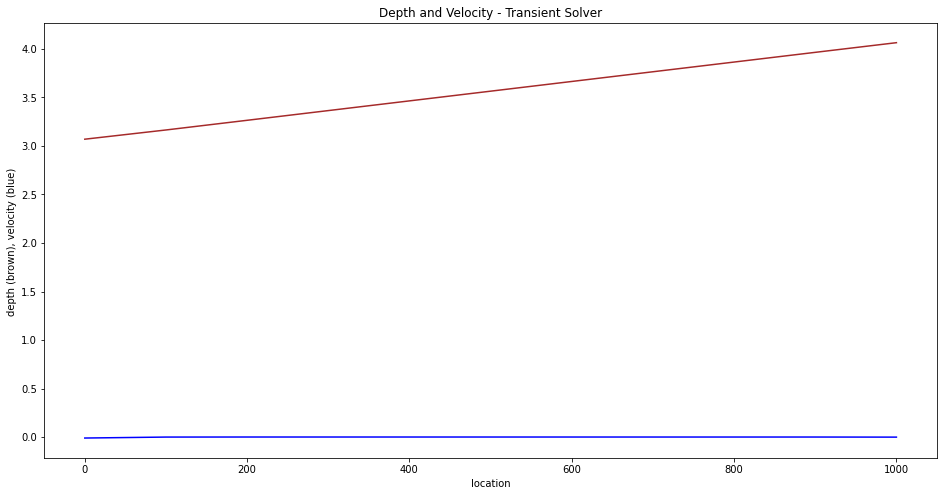

__________
Time =  611166.9869617781  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


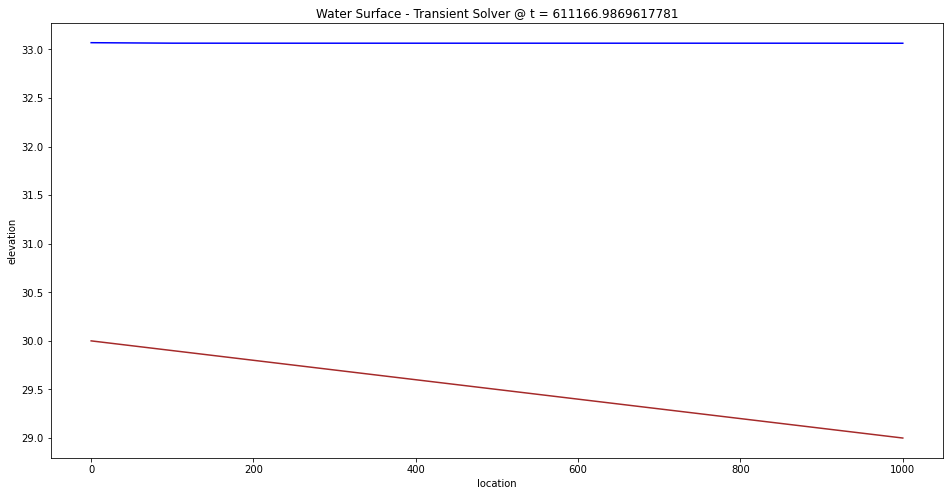

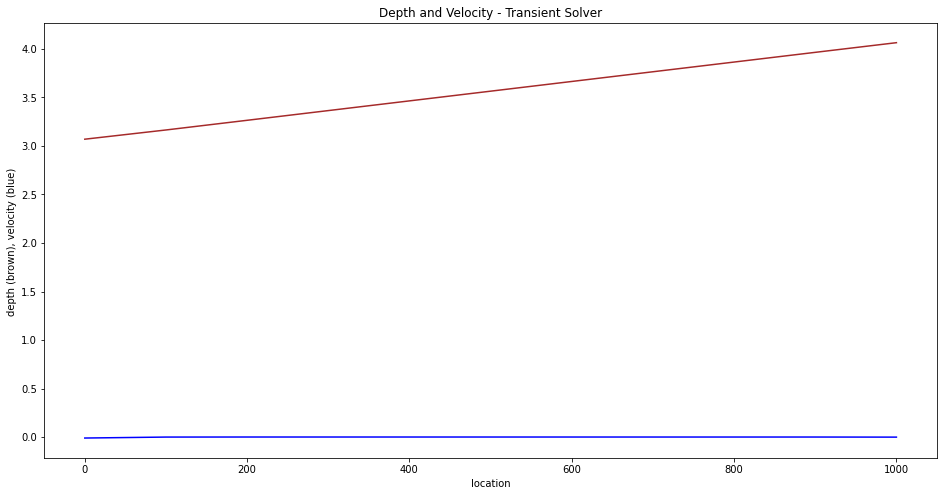

__________
Time =  629149.3261456945  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


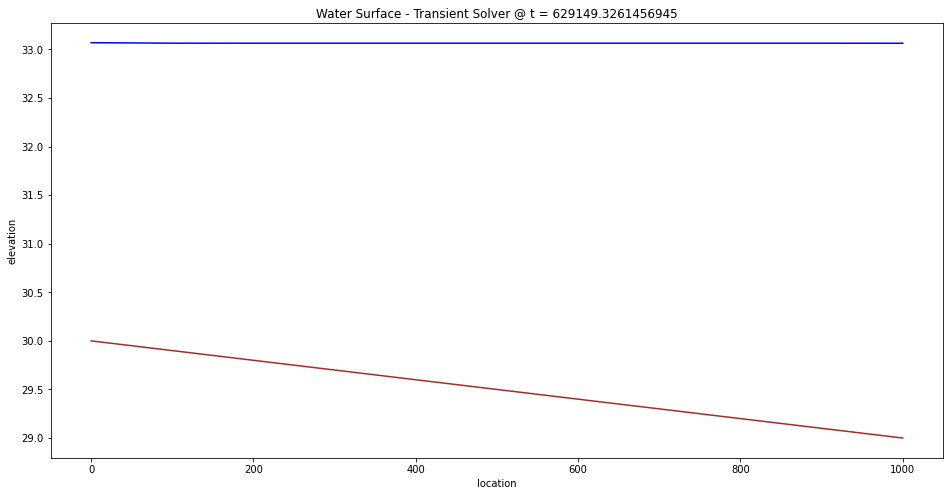

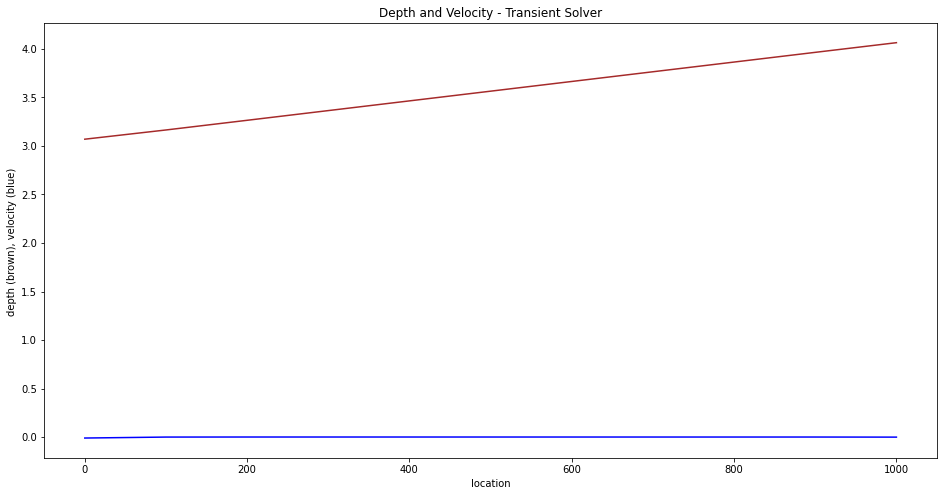

__________
Time =  647131.6653296108  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


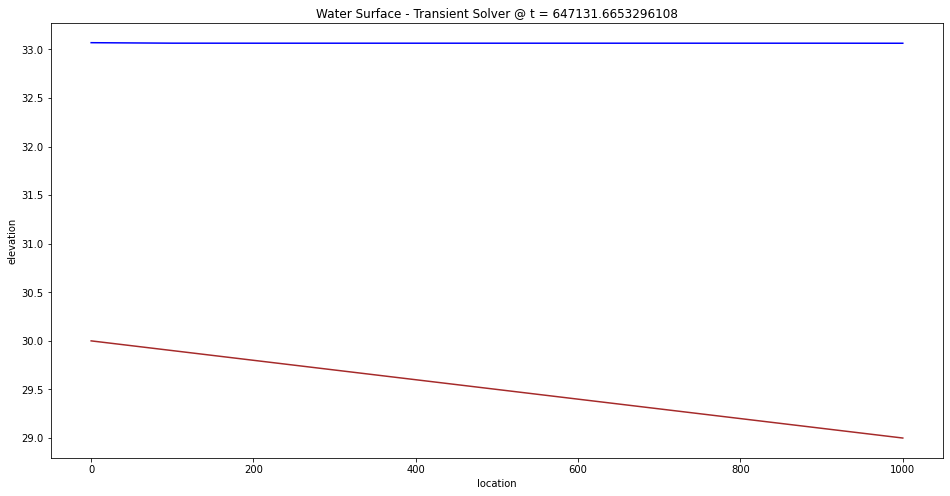

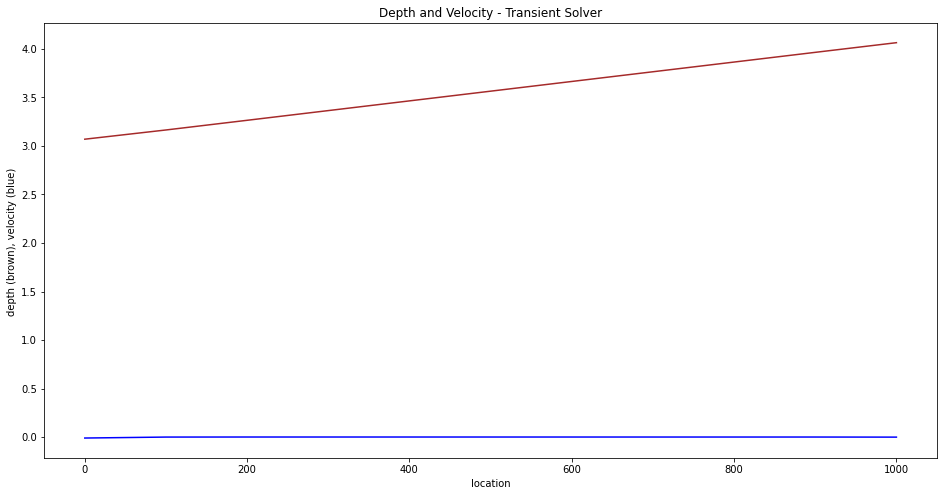

__________
Time =  665114.0045135272  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


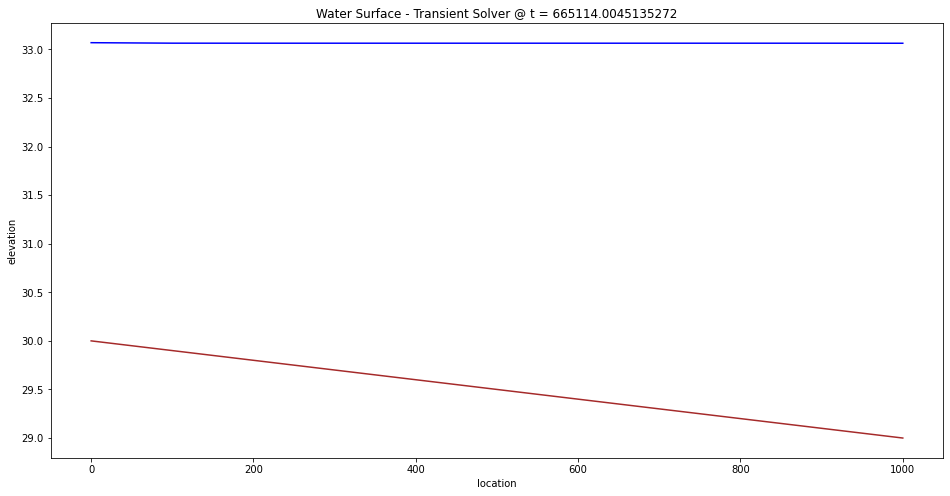

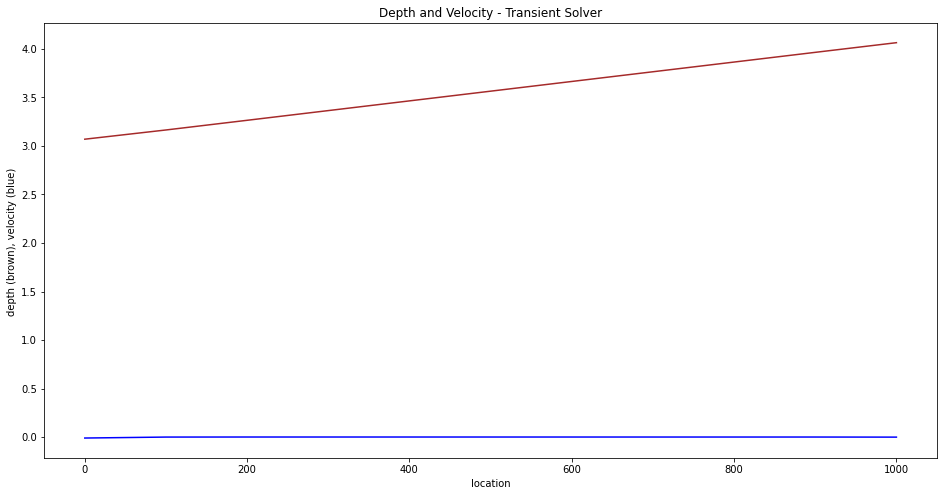

__________
Time =  683096.3436974435  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


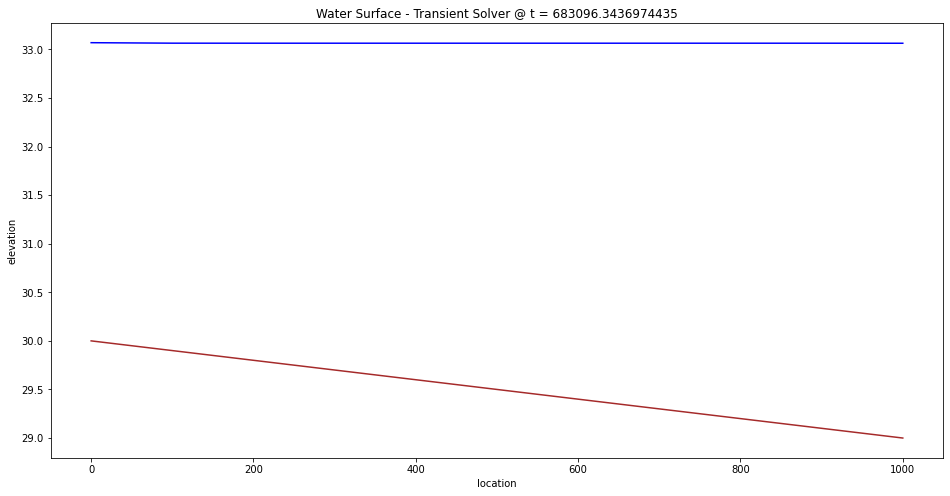

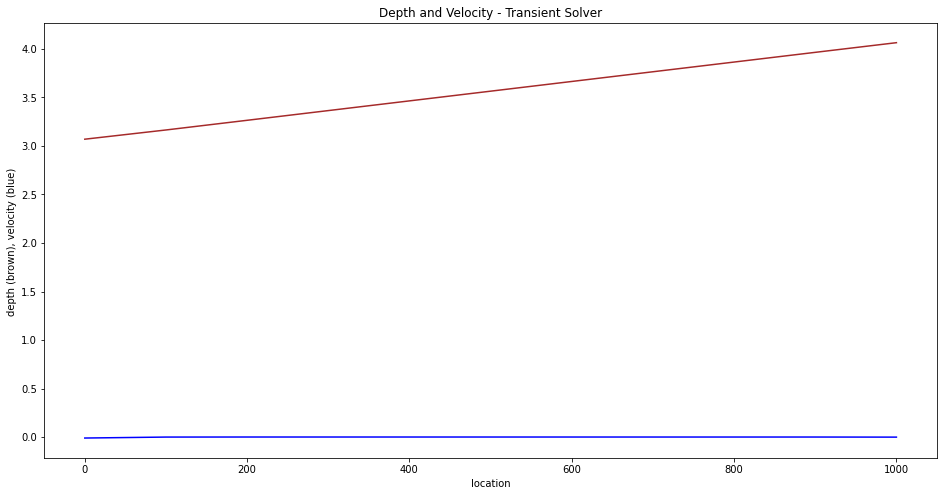

__________
Time =  701078.6828813598  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


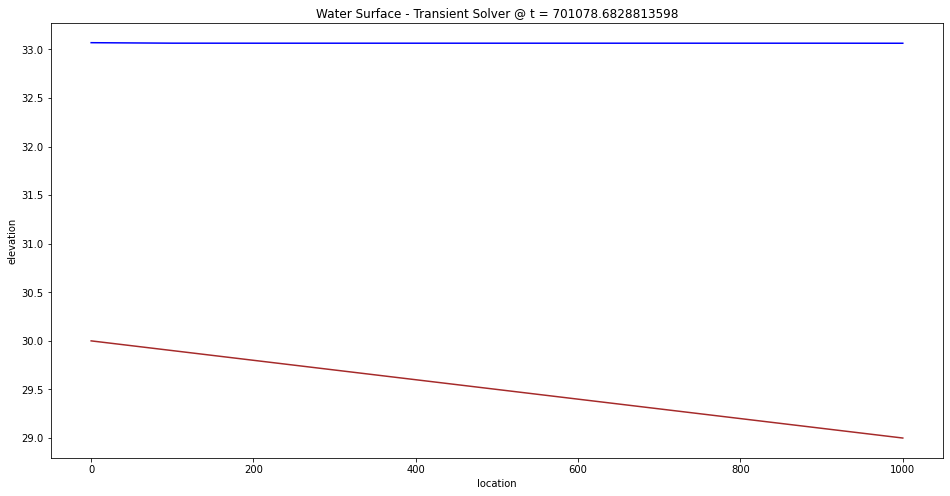

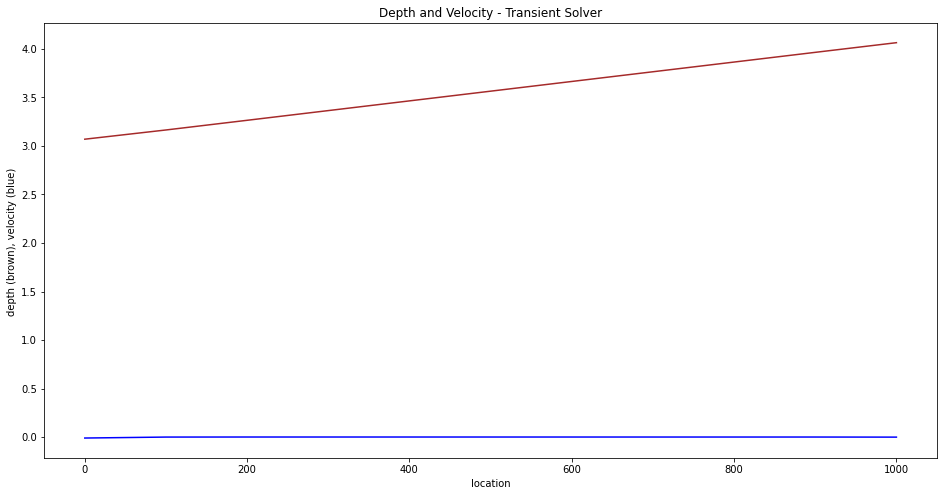

__________
Time =  719061.0220652762  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


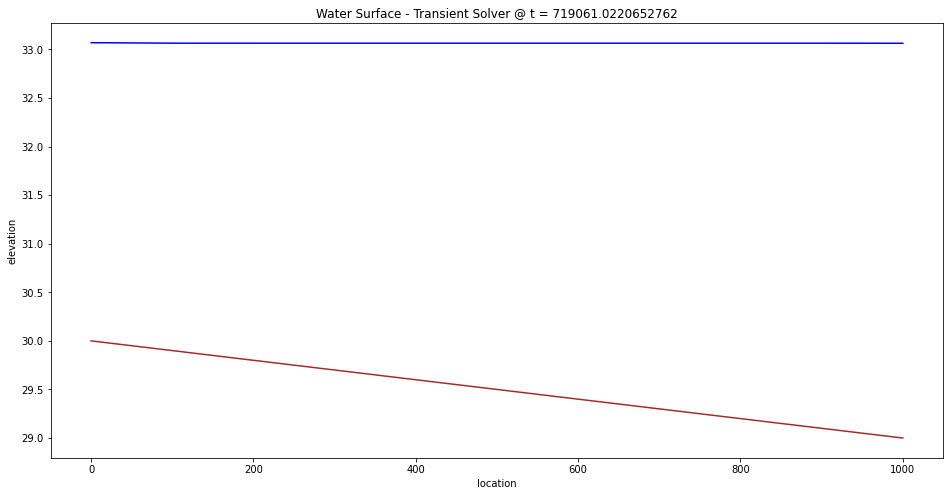

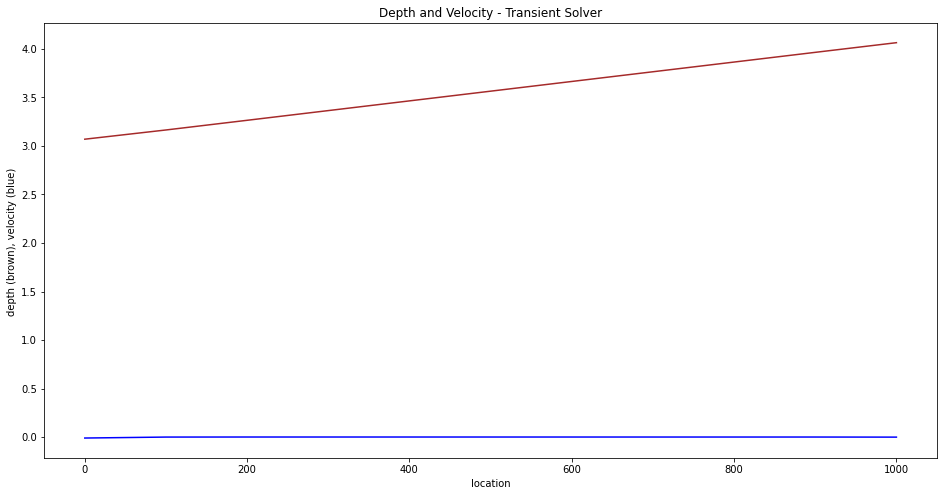

__________
Time =  737043.3612491925  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


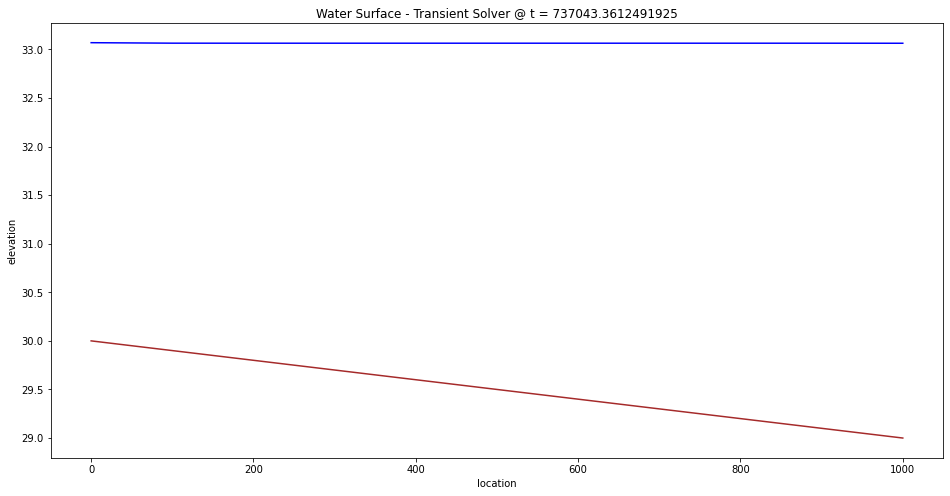

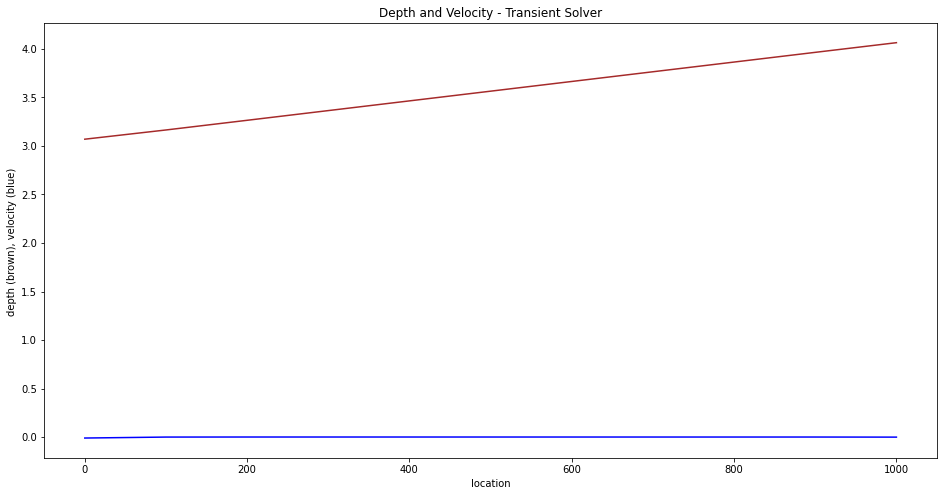

__________
Time =  755025.7004331088  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


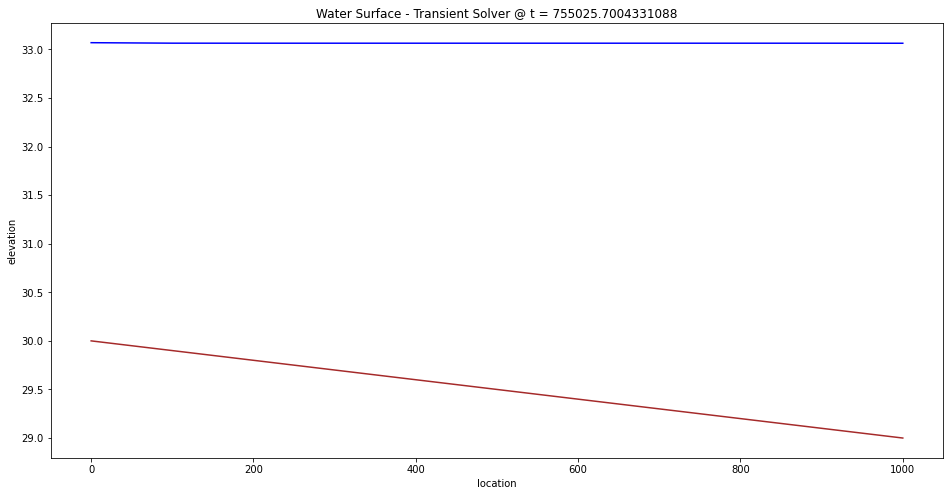

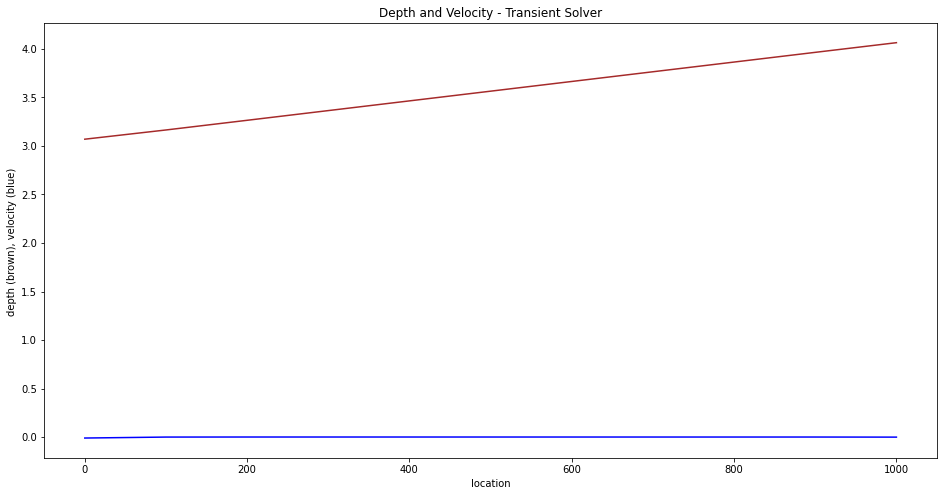

__________
Time =  773008.0396170252  seconds. Time step length =  17.98233918392096  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


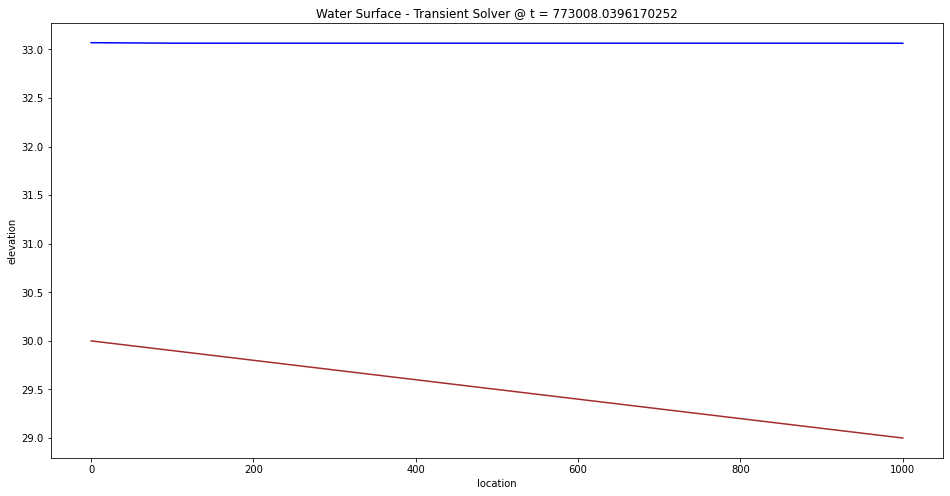

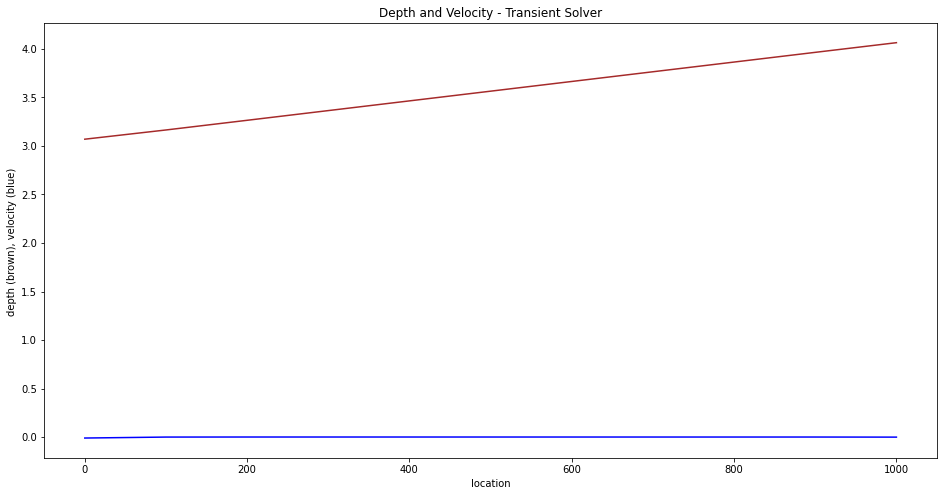

__________
Time =  790990.3788009415  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


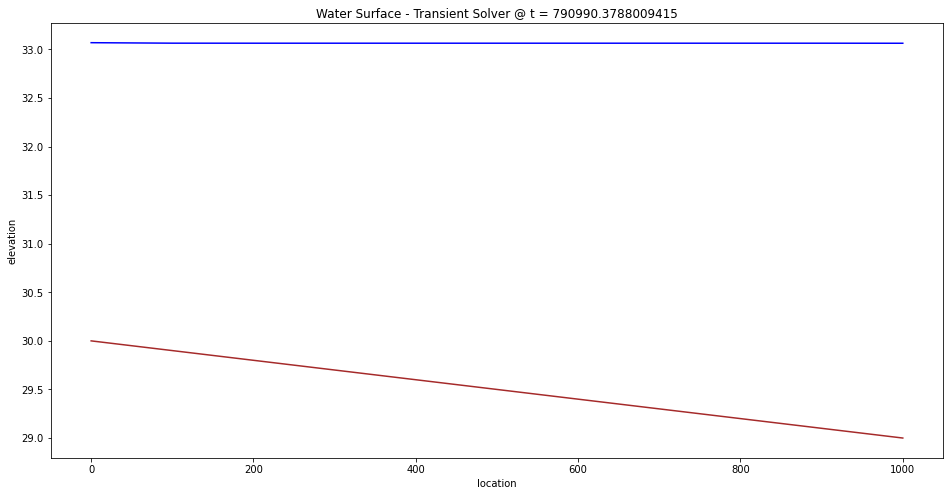

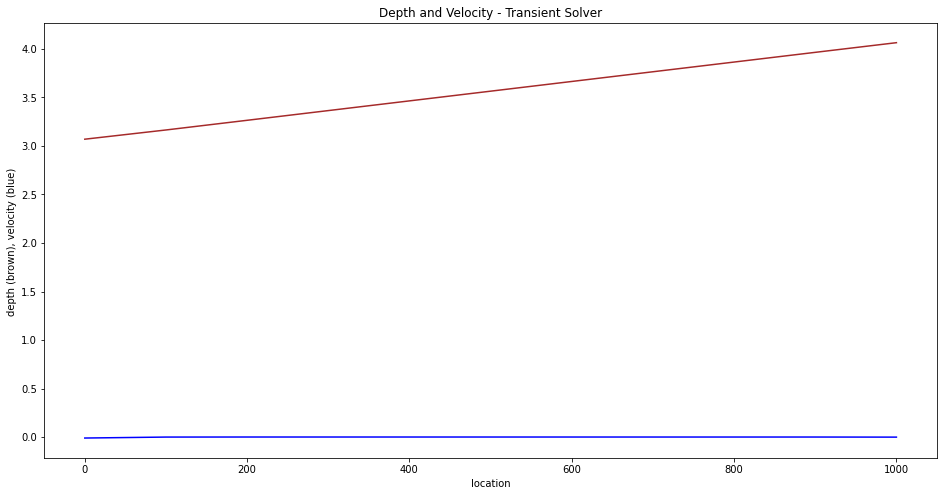

__________
Time =  808972.7179848579  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


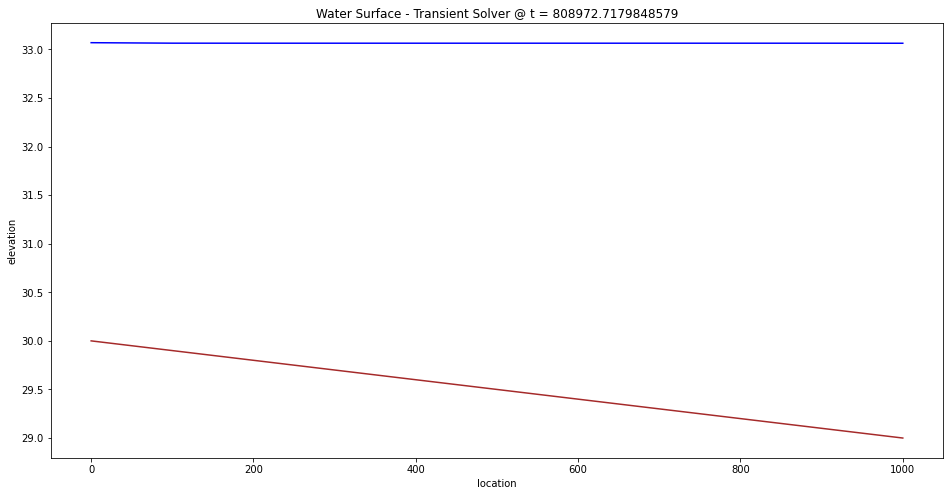

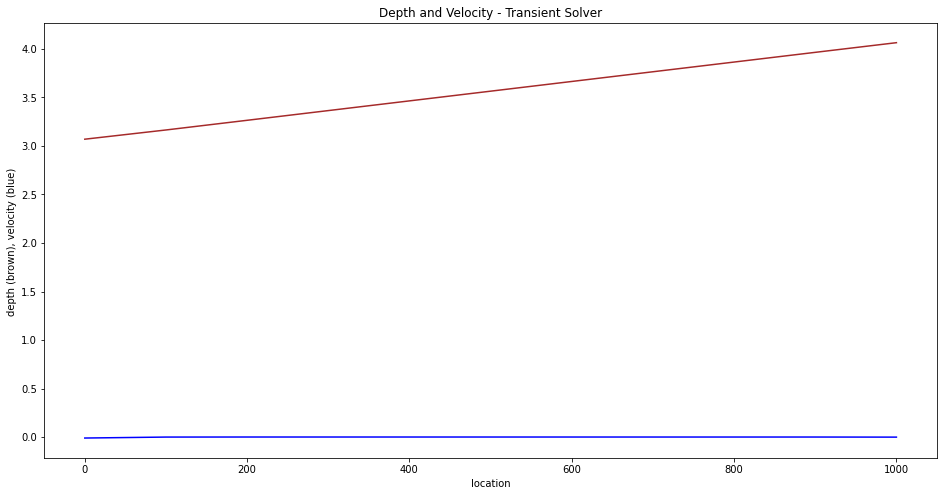

__________
Time =  826955.0571687742  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


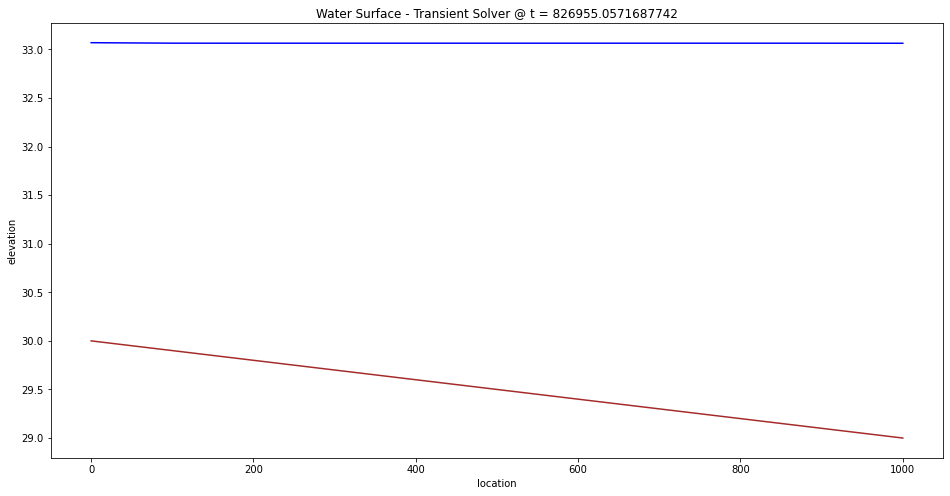

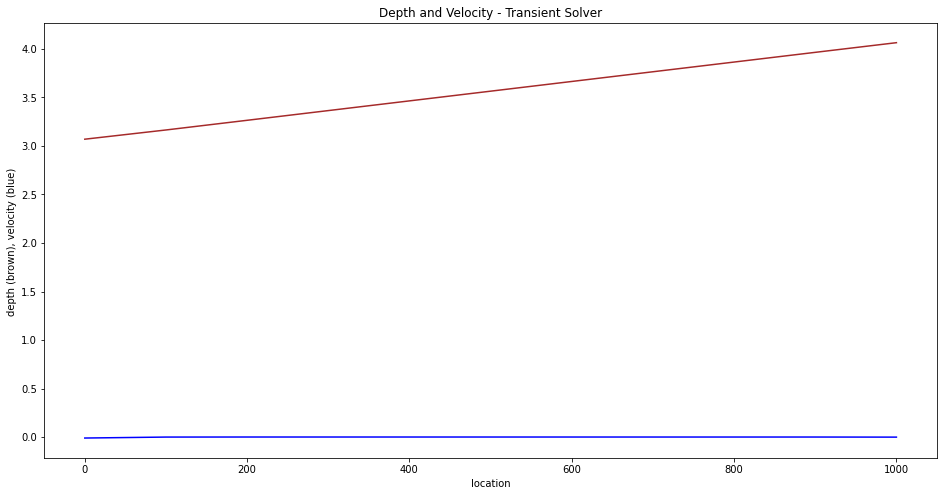

__________
Time =  844937.3963526905  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


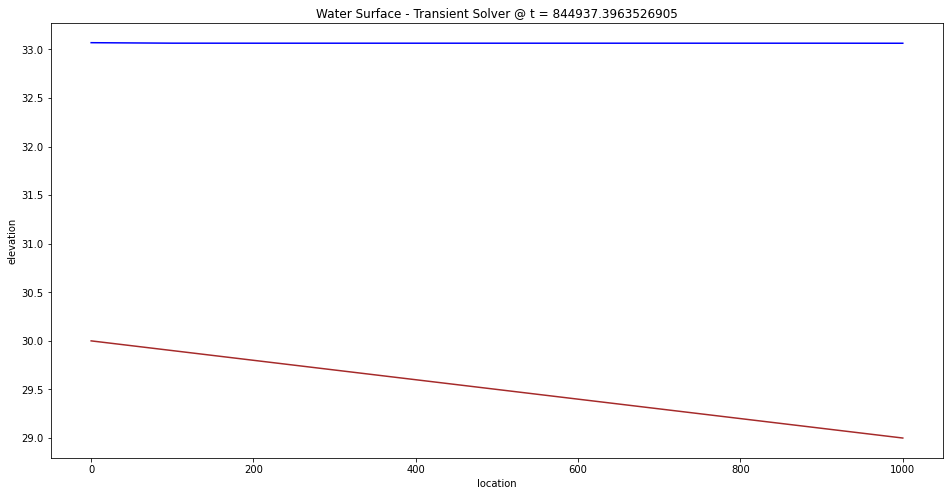

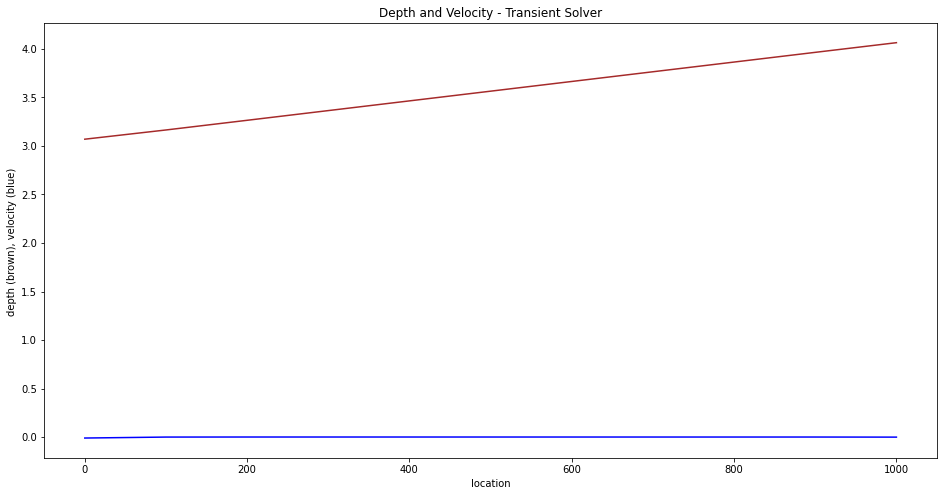

__________
Time =  862919.7355366069  seconds. Time step length =  17.982339183920946  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


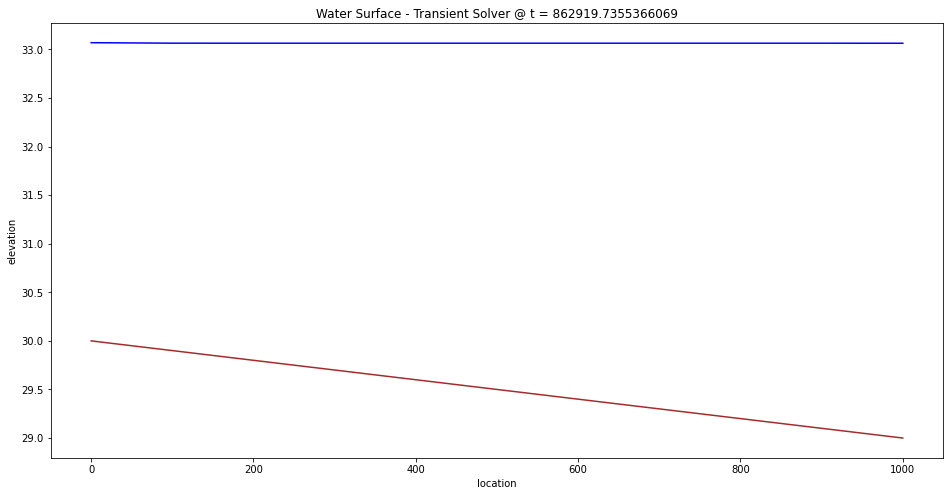

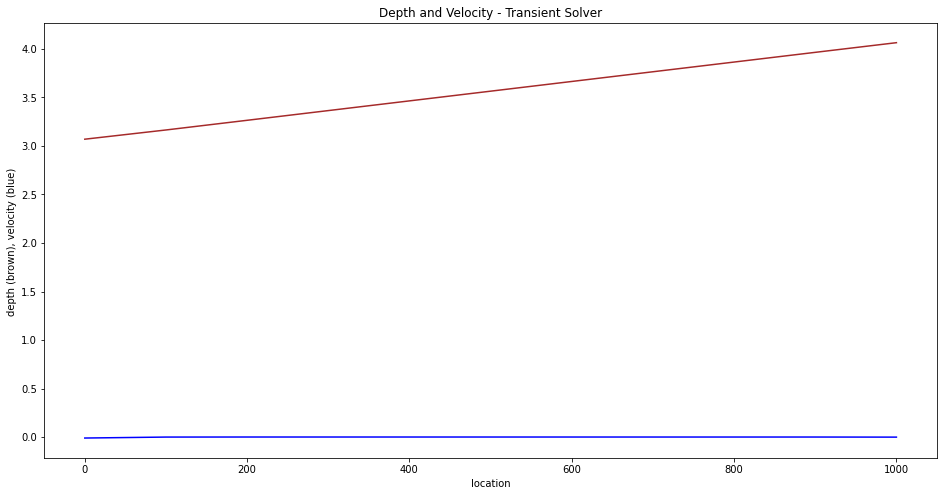

__________
Time =  880902.0747205232  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


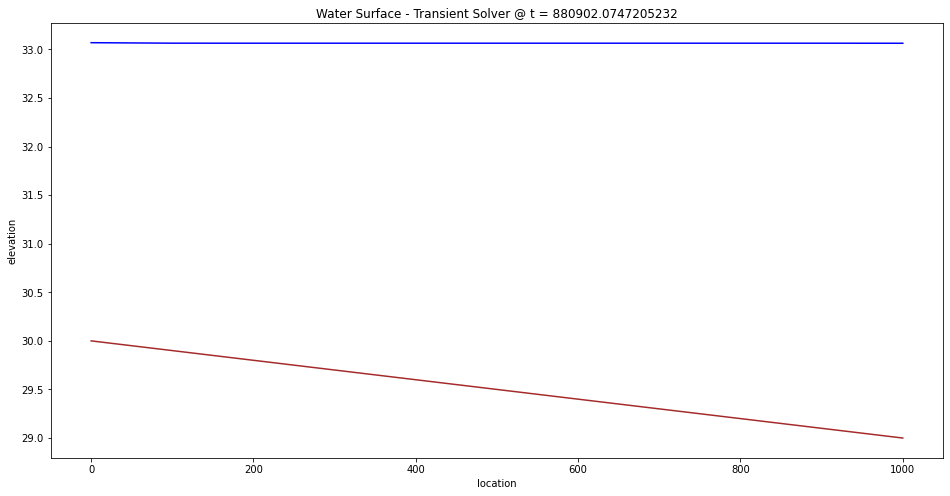

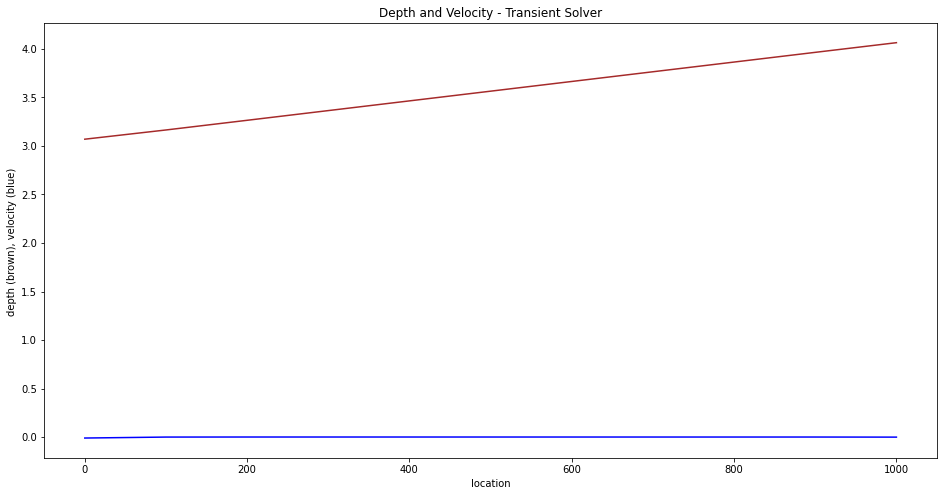

__________
Time =  898884.4139044395  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


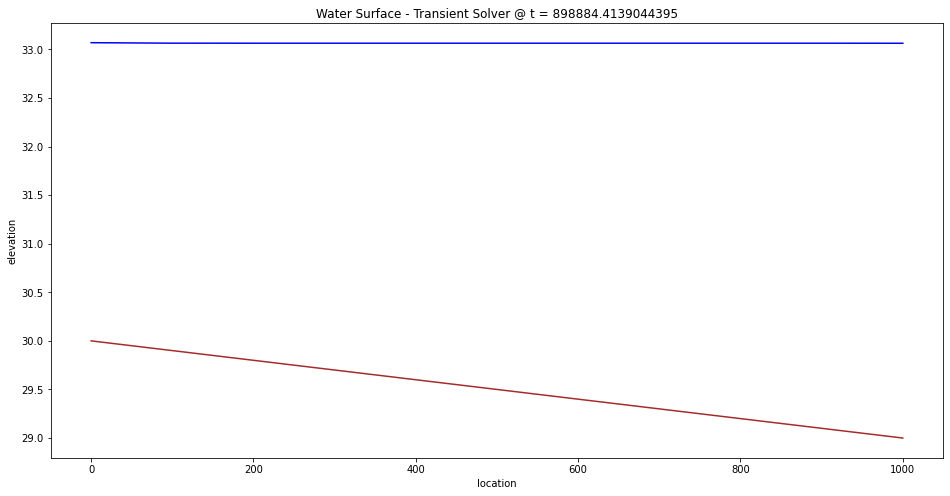

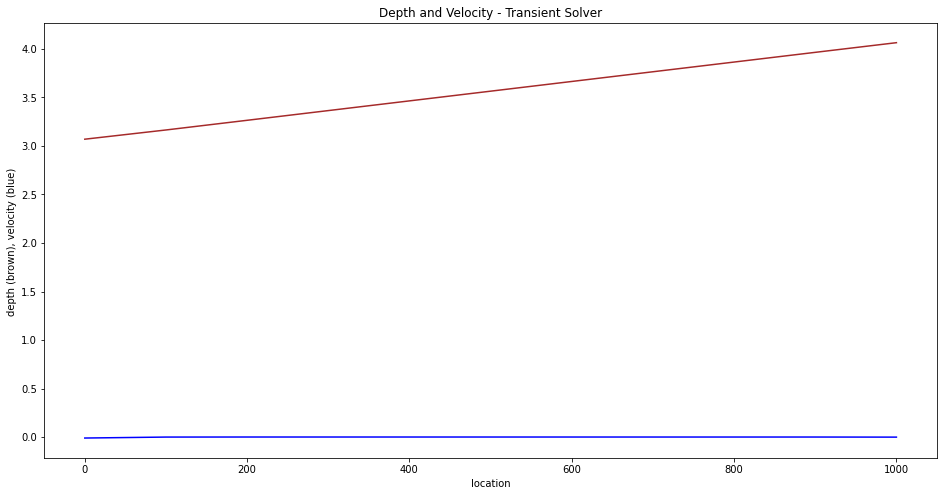

__________
Time =  916866.7530883559  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


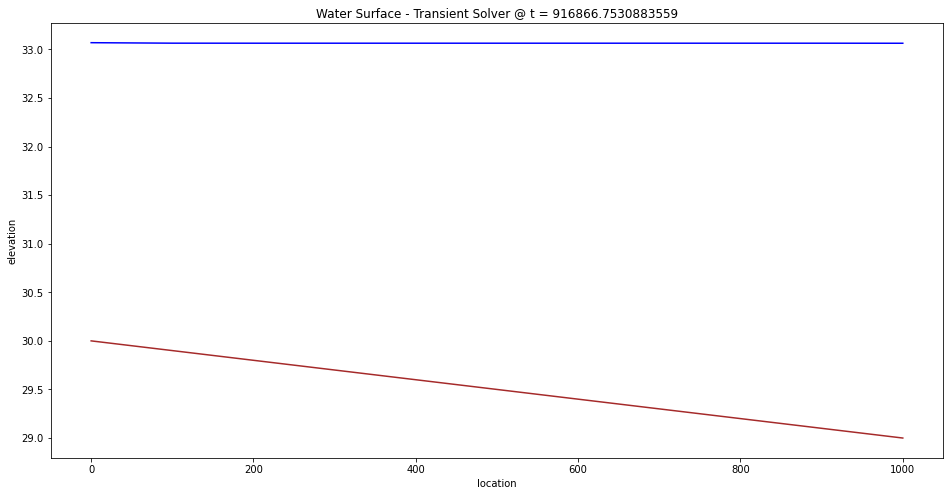

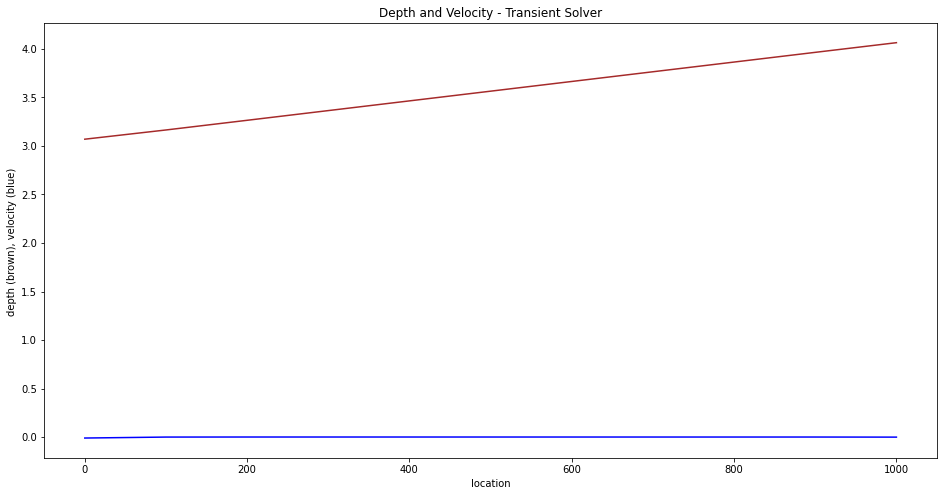

__________
Time =  934849.0922722722  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


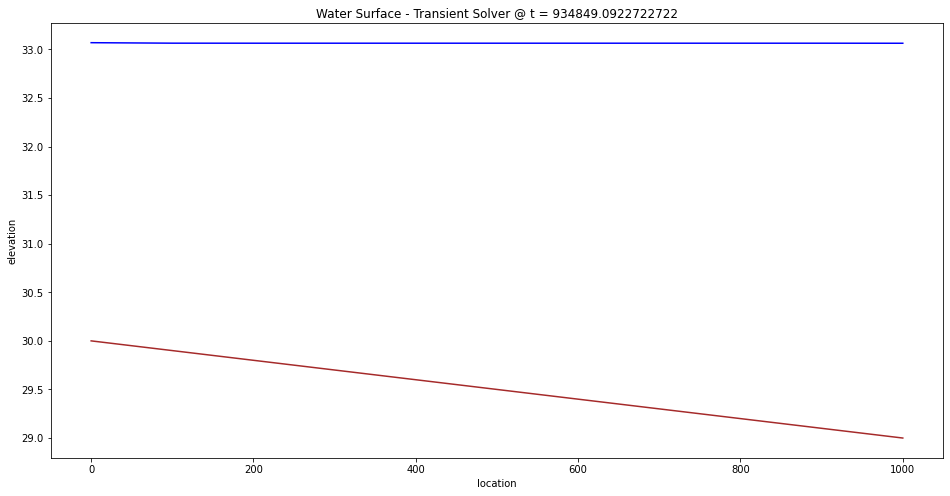

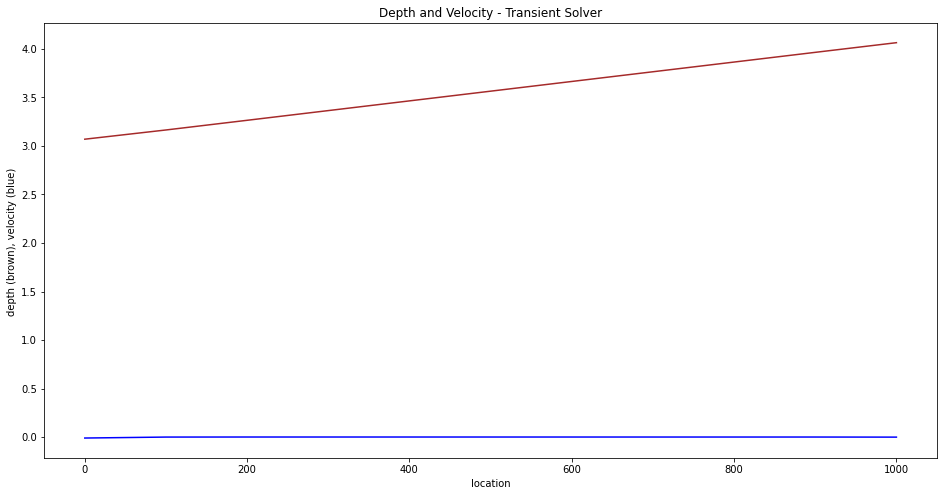

__________
Time =  952831.4314561886  seconds. Time step length =  17.982339183920953  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


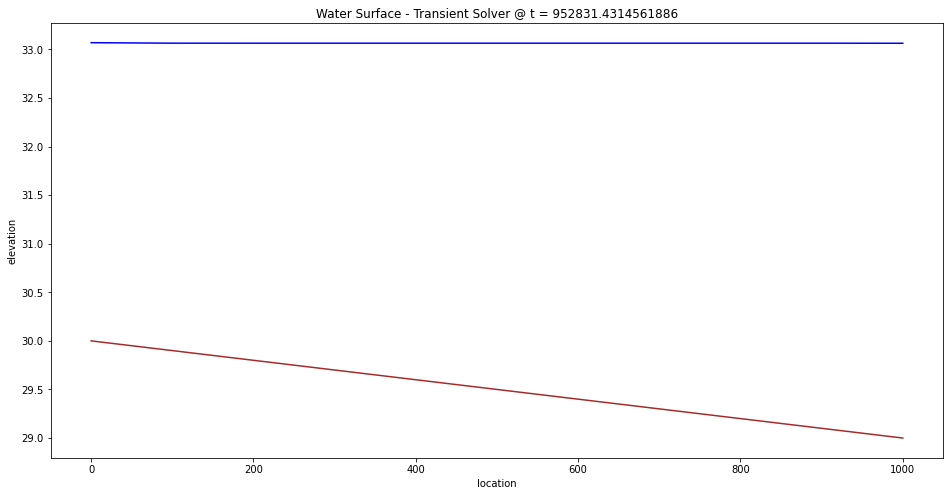

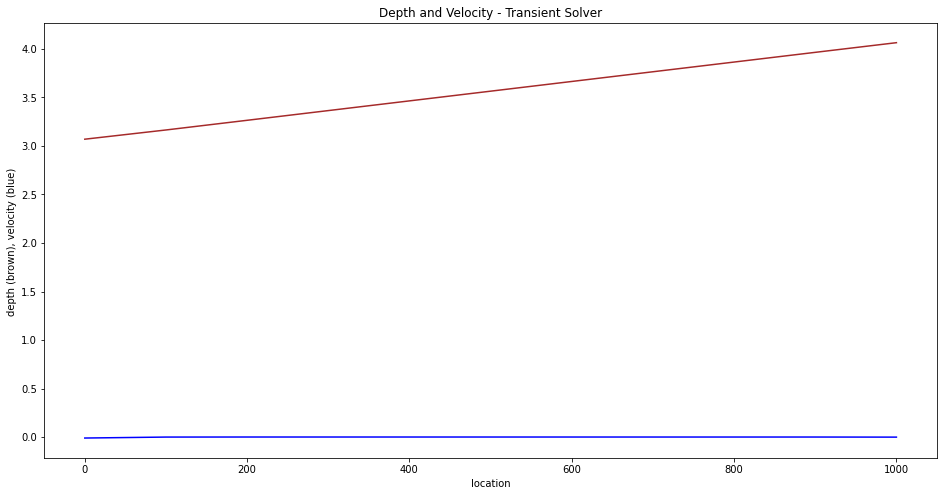

__________
Time =  970813.7706401049  seconds. Time step length =  17.982339183920956  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


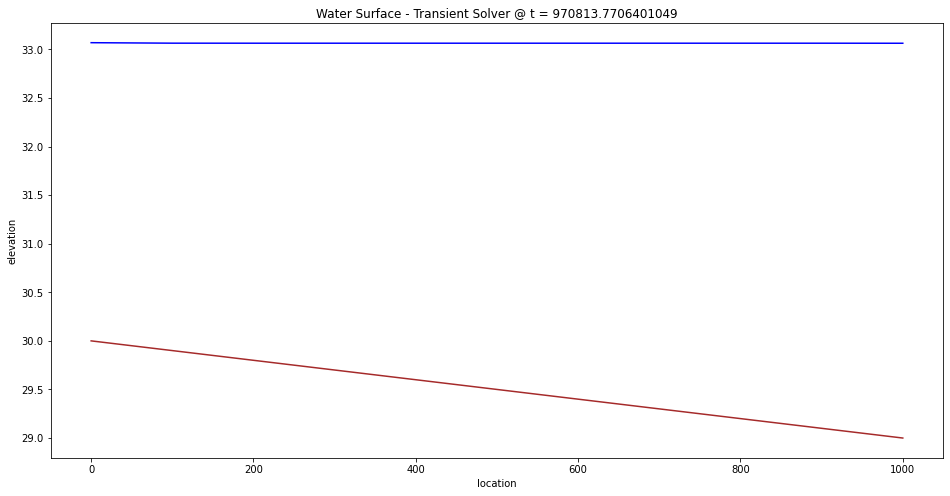

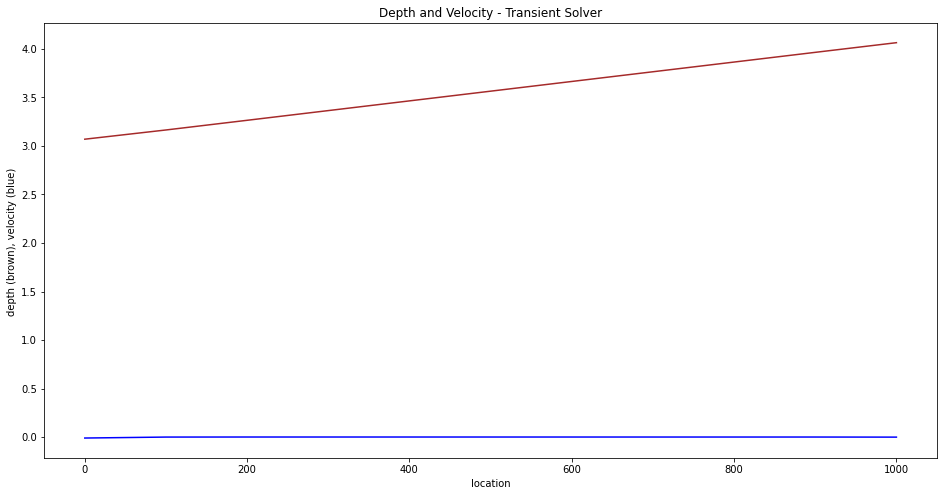

__________
Time =  982933.8672500645  seconds. Time step length =  35.96467836784191  seconds 
IROW   DEPTH   VELOCITY 
0 3.069 -0.009
1 3.164 0.001
2 3.264 0.001
3 3.364 0.001
4 3.464 0.001
5 3.564 0.001
6 3.664 0.001
7 3.764 0.001
8 3.864 0.001
9 3.964 0.001
10 4.063 0.0


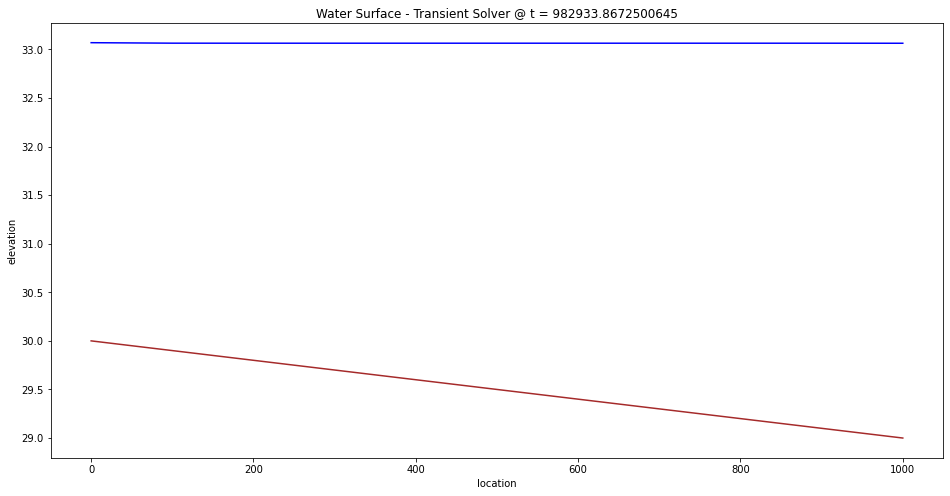

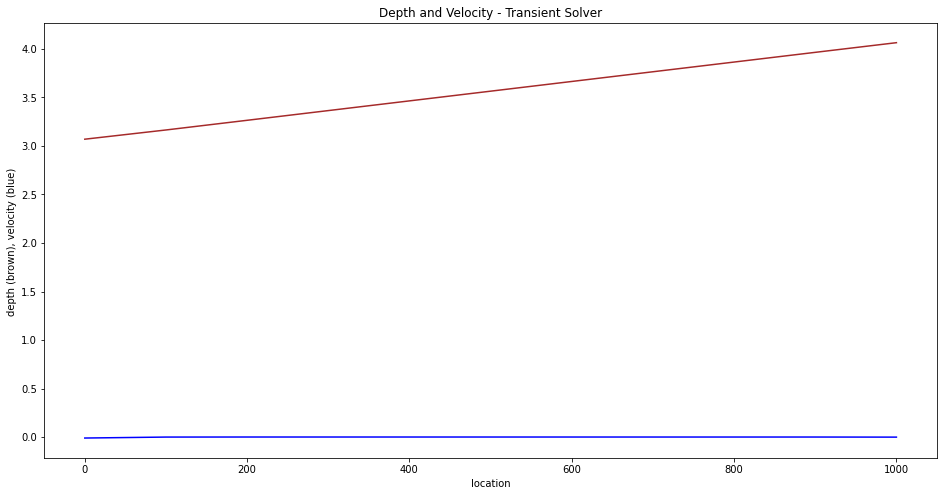

In [110]:
k = 0 # time counter
t = 0.0 # elapsed time
writenow(t,dt,y,v,bw[0],ss[0])
for i in range(0,nn):
    wse[i]=bse[i]+y[i]
plot2lines(xx,bse,xx,wse,"location","elevation","Water Surface - Transient Solver @ t = "+str(t))
plot2lines(xx,y,xx,v,"location","depth (brown), velocity (blue) ","Depth and Velocity - Transient Solver")
for itime in range(0,kmax): # begin time stepping loop scope
#print('Iteration Count = ',itime)
######## Adaptive Time Step Based on Current mesh courant number ###
    bestdt = dt # start with current time step
### begin courant number each cell loop scope
    for i in range(0,nn):
        a = ar(y[i],bw[i],ss[i]);
        b = bt(y[i],bw[i],ss[i]);
        c = math.sqrt(g*a/b);
        dtn = dx/abs((v[i])+c)
    # now test
        if(dtn < bestdt):
            bestdt = dtn
### end courant number each cell loop scope
    dt = bestdt
#print('time-step length = ',dt)
#writenow(t,dt,y,v,b0,s)

    #print(v[n],vp[n])
###### Finite Difference #################################
    r = 0.5*dt/dx;
###### LEFT BOUNDARY #####################################
# UPSTREAM FIXED STAGE AT PRESCRIBED NORMAL DEPTH        #
##########################################################
    yp[0] = yu
    ab = ar(y[1],bw[1],ss[1]);
    bb = bt(y[1],bw[1],ss[1]);
    cb = math.sqrt(g*bb/ab);
    rb = ab/wp(y[1],bw[1],ss[1]);
    sfb = (mn2*v[1]*v[1])/(rb**(1.333));
    cn = v[1] -cb*y[1]+ g*(s0-sfb)*dt;
    vp[0] = cn + cb*yp[0];
###### RIGHT BOUNDARY ####################################
#         FIXED STAGE AT DOWNSTREAM END                  #
##########################################################
# fixed stage boundary, find velocity along a characteristic
#    yp[n-1] = yd ;
#    aa = ar(y[n-1],bw[n-1],ss[n-1]);
#    ba = bt(y[n-1],bw[n-1],ss[n-1]);
#    ca = math.sqrt(g*ba/aa);
#    ra = aa/wp(y[n-1],bw[n-1],ss[n-1]);
#    sfa = (mn2*v[n-1]*v[n-1])/(ra**(4.0/3.0));
#    cp = v[n-1] + ca*y[n-1]+g*(s0-sfa)*dt;
##yp[nn] <<- (cp - vp[nn])/ca;
#    vp[n] = cp - yp[n]*ca 

###### RIGHT BOUNDARY ####################################
# REFLECTION BOUNDARY AT DOWNSTREAM END                  #
##########################################################
# reflection boundary, find depth along a characteristic
    vp[n] = 0. ;
    aa = ar(y[n-1],bw[n-1],ss[n-1]);
    ba = bt(y[n-1],bw[n-1],ss[n-1]);
    ca = math.sqrt(g*ba/aa);
    ra = aa/wp(y[n-1],bw[n-1],ss[n-1]);
    sfa = (mn2*v[n-1]*v[n-1])/(ra**(4.0/3.0));
    cp = v[n-1] + ca*y[n-1]+g*(s0-sfa)*dt;
    yp[n] = (cp - vp[n])/ca;
######## INTERIOR NODES AND REACHES ###############
### loop through the interior nodes
    for i in range(1,n): # begin interior node loop scope
        aa = ar(y[i-1],bw[i-1],ss[i-1]);
        ba = bt(y[i-1],bw[i-1],ss[i-1]);
        pa = wp(y[i-1],bw[i-1],ss[i-1]);
        ra = aa/pa;
        sfa = (mn2*v[i-1]*v[i-1])/(ra**(4.0/3.0));
        ab = ar(y[i+1],bw[i+1],ss[i+1]);
        bb = bt(y[i+1],bw[i+1],ss[i+1]);
        pb = wp(y[i+1],bw[i+1],ss[i+1]);
        rb = ab/pb;
        sfb = (mn2*v[i+1]*v[i+1])/(rb**(4.0/3.0));
# need averages of sf, hydraulic depth
        dm = 0.5*(aa/ba + ab/bb);
        sfm = 0.5*(sfa+sfb);
        vm = 0.5*(v[i-1]+v[i+1]);
        ym = 0.5*(y[i-1]+y[i+1]);
# new momentum
        vp[i] = vm -r*g*(y[i+1] - y[i-1]) -r*vm*(v[i+1] - v[i-1]) + g*dt*(s0-sfm);
# new depth
        yp[i] = ym - r*dm*(v[i+1] - v[i-1]) -r*vm*(y[i+1] - y[i-1]);
### end of interior node loop scope
# update time, count, depth and momentum
    t = t+dt; # Increment simulation time
    k = k+1; # Increment loop counter
    for i in range(0,n+1):
        v[i]=vp[i]
        y[i]=yp[i]
    if (k%iprt == 0): # Write current conditions every iprt time steps
        writenow(t,dt,y,v,bw[0],ss[0])
        for i in range(0,nn):
            wse[i]=bse[i]+y[i]
        plot2lines(xx,bse,xx,wse,"location","elevation","Water Surface - Transient Solver @ t = "+str(t))
        plot2lines(xx,y,xx,v,"location","depth (brown), velocity (blue) ","Depth and Velocity - Transient Solver")
    dt = 2*dt #artificially inflate the time step to force adaptive update
    #print(v[n],vp[n])
# end time step loop

# provisional code to make a plot
writenow(t,dt,y,v,bw[0],ss[0])
for i in range(0,nn):
    wse[i]=bse[i]+y[i]
plot2lines(xx,bse,xx,wse,"location","elevation","Water Surface - Transient Solver @ t = "+str(t))
plot2lines(xx,y,xx,v,"location","depth (brown), velocity (blue) ","Depth and Velocity - Transient Solver")

In [51]:
v[10]

1.371271478567987